In [1]:
%load_ext autoreload 
%autoreload 2 

import numpy as np
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
from tensorflow.keras import datasets, layers, models, optimizers, callbacks


from utils import display, sample_batch

2023-08-04 01:34:23.077188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 01:34:23.163131: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-04 01:34:23.184137: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-04 01:34:23.500782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1 Physical GPUs, 1 Logical GPUs


### Parameters 

In [5]:
IMAGE_SIZE = 16 
PIXEL_LEVELS = 4 
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

In [3]:
(x_train,_), (_,_) = datasets.fashion_mnist.load_data()

In [6]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

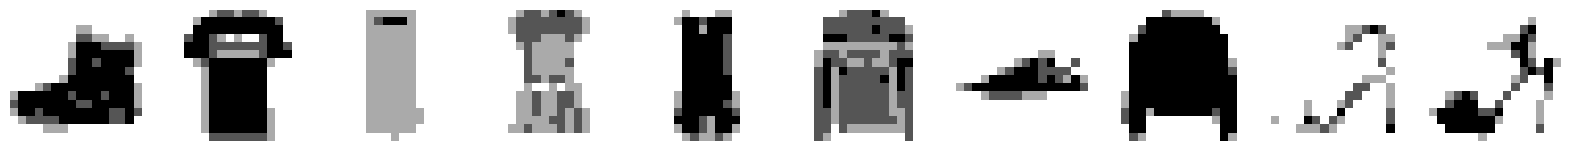

In [7]:
display(input_data)

### Build the PixelCNN

In [9]:
#The first layer is the PixelCNN layer. This layer simply builds on the 2D convolutional layer, but includes masking 

class MaskedConv2D(layers.Layer):
    def __init__(self,mask_type,**kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)
        
    def build(self,input_shape):
        #Build the conv2D layer to initialize kernel variables 
        self.conv.build(input_shape)
        
        #Use the initialized kernel to create the mask 
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0 
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0 
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] //2, ...] = 1.0 
            
    def call(self,inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)
    
    def get_config(self):
        cfg = super().get_config()
        return cfg 

In [10]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters = filters // 2, kernel_size=1, activation="relu")
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters = filters // 2, 
            kernel_size = 3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters = filters, kernel_size=1, activation="relu"
        )
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs,x])
    
    def get_config(self):
        cfg = super().get_config()
        return cfg

In [12]:
inputs = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)
    
for _ in range(2):
    x = MaskedConv2D(
        mask_type = "B",
        filters = N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)
out = layers.Conv2D(
    filters = PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)
pixel_cnn = models.Model(inputs,out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d_8 (MaskedConv  (None, 16, 16, 128)      6400      
 2D)                                                             
                                                                 
 residual_block_5 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                           
                                                                 
 residual_block_6 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                           
                                                                 
 residual_block_7 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                       

###  Train the PixelCNN

In [13]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [14]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

In [16]:
output_data[0]

array([[[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [2],
        [2],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0]],

       [[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [3],
        [3],
        [3],
        [2],
    

Epoch 1/150


2023-08-04 02:21:56.655360: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-08-04 02:21:57.431903: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


469/469 [==============================] - ETA: 0s - loss: 0.4908
Saved to ./output/generated_img_000.png


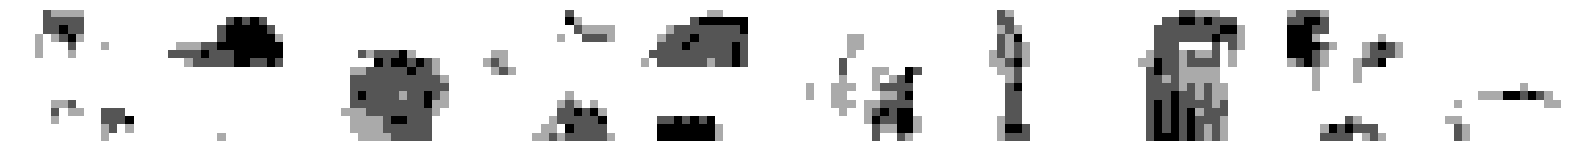

469/469 [==============================] - 17s 31ms/step - loss: 0.4908
Epoch 2/150
467/469 [============================>.] - ETA: 0s - loss: 0.4017
Saved to ./output/generated_img_001.png


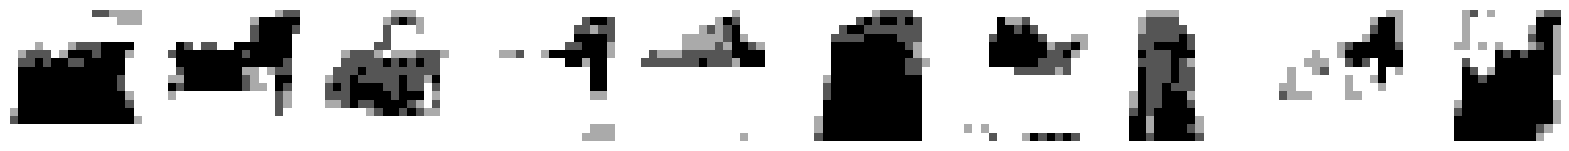

469/469 [==============================] - 14s 31ms/step - loss: 0.4017
Epoch 3/150
466/469 [============================>.] - ETA: 0s - loss: 0.3888
Saved to ./output/generated_img_002.png


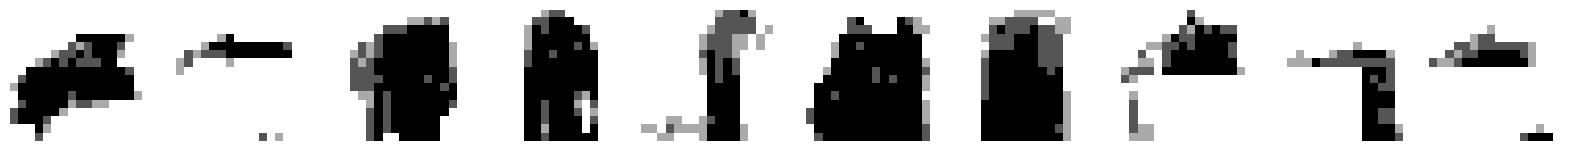

469/469 [==============================] - 15s 31ms/step - loss: 0.3887
Epoch 4/150
467/469 [============================>.] - ETA: 0s - loss: 0.3820
Saved to ./output/generated_img_003.png


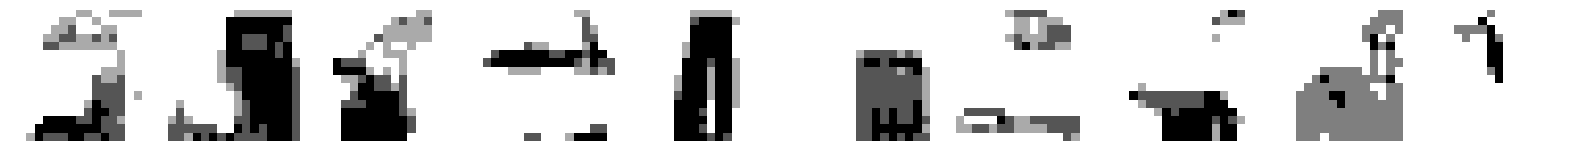

469/469 [==============================] - 15s 31ms/step - loss: 0.3820
Epoch 5/150
469/469 [==============================] - ETA: 0s - loss: 0.3772
Saved to ./output/generated_img_004.png


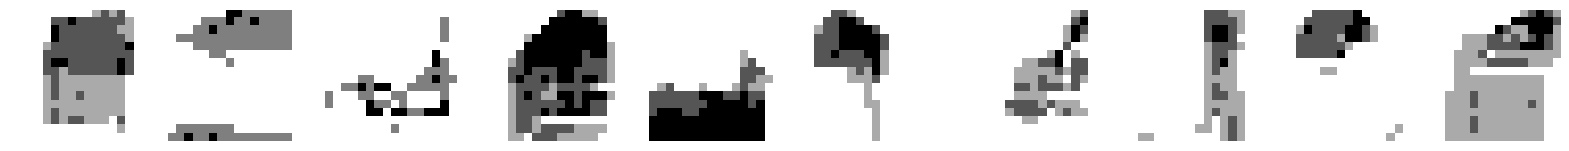

469/469 [==============================] - 15s 32ms/step - loss: 0.3772
Epoch 6/150
469/469 [==============================] - ETA: 0s - loss: 0.3737
Saved to ./output/generated_img_005.png


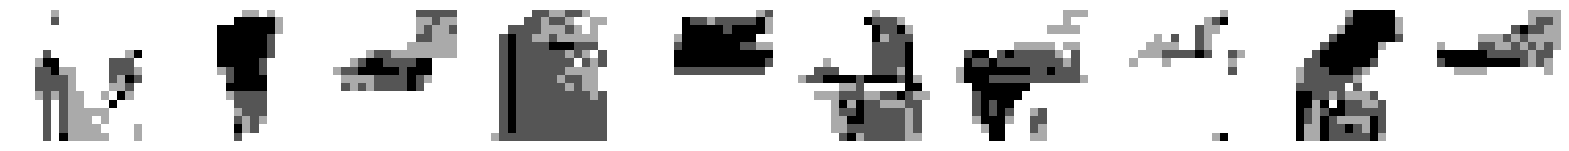

469/469 [==============================] - 15s 31ms/step - loss: 0.3737
Epoch 7/150
467/469 [============================>.] - ETA: 0s - loss: 0.3702
Saved to ./output/generated_img_006.png


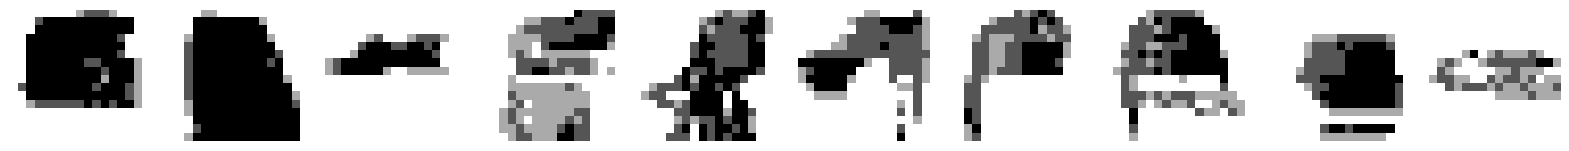

469/469 [==============================] - 15s 32ms/step - loss: 0.3702
Epoch 8/150
466/469 [============================>.] - ETA: 0s - loss: 0.3678
Saved to ./output/generated_img_007.png


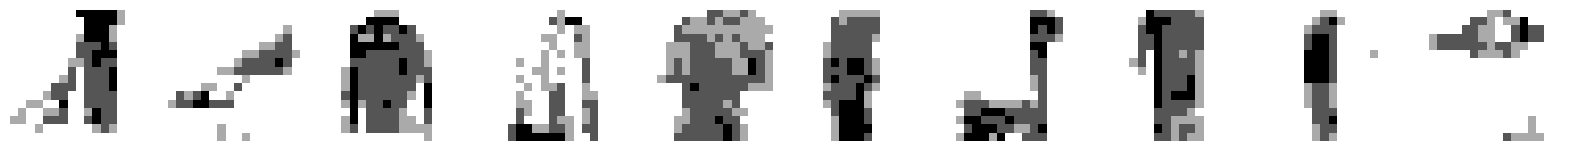

469/469 [==============================] - 15s 32ms/step - loss: 0.3678
Epoch 9/150
468/469 [============================>.] - ETA: 0s - loss: 0.3649
Saved to ./output/generated_img_008.png


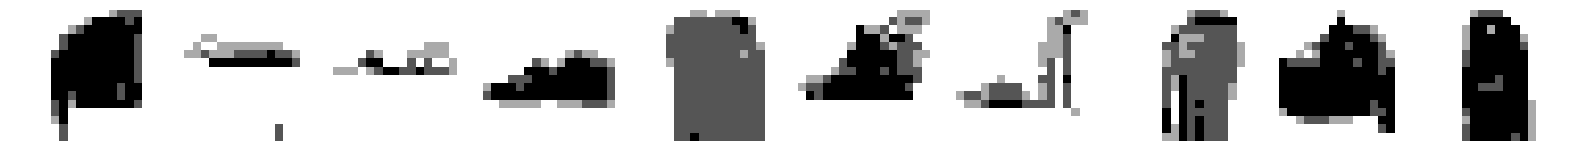

469/469 [==============================] - 15s 31ms/step - loss: 0.3649
Epoch 10/150
467/469 [============================>.] - ETA: 0s - loss: 0.3630
Saved to ./output/generated_img_009.png


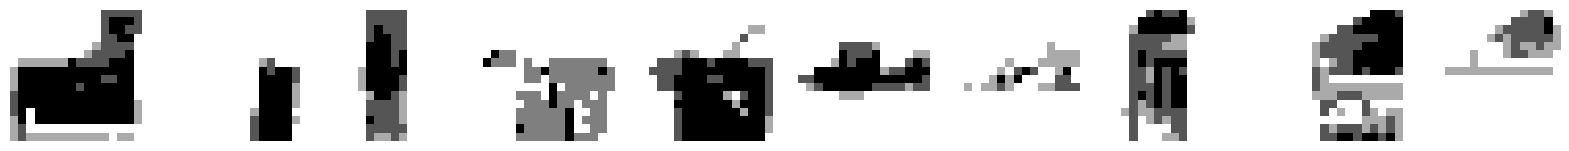

469/469 [==============================] - 15s 32ms/step - loss: 0.3630
Epoch 11/150
467/469 [============================>.] - ETA: 0s - loss: 0.3607
Saved to ./output/generated_img_010.png


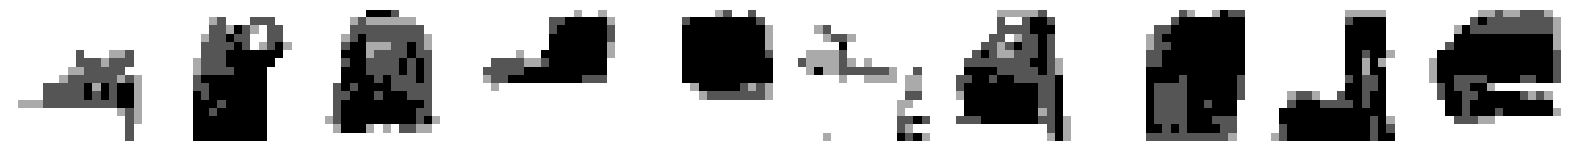

469/469 [==============================] - 15s 31ms/step - loss: 0.3608
Epoch 12/150
466/469 [============================>.] - ETA: 0s - loss: 0.3588
Saved to ./output/generated_img_011.png


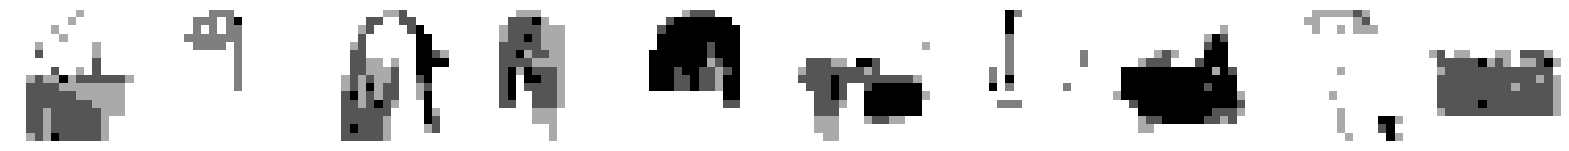

469/469 [==============================] - 15s 32ms/step - loss: 0.3588
Epoch 13/150
466/469 [============================>.] - ETA: 0s - loss: 0.3572
Saved to ./output/generated_img_012.png


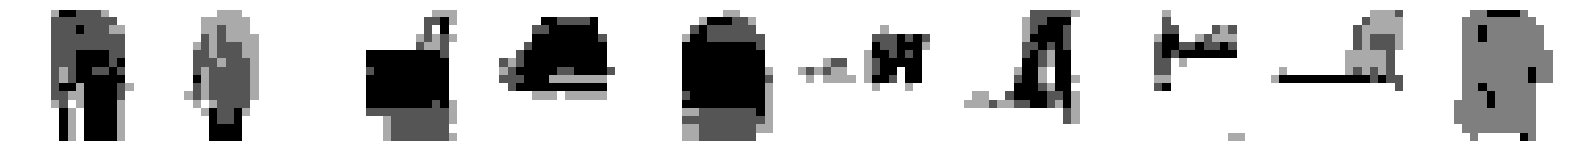

469/469 [==============================] - 15s 31ms/step - loss: 0.3572
Epoch 14/150
468/469 [============================>.] - ETA: 0s - loss: 0.3556
Saved to ./output/generated_img_013.png


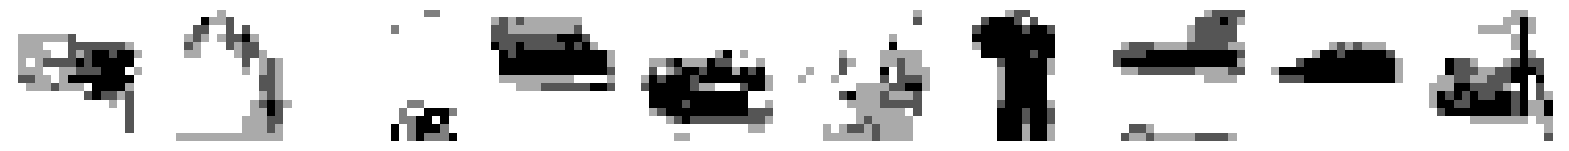

469/469 [==============================] - 15s 32ms/step - loss: 0.3556
Epoch 15/150
468/469 [============================>.] - ETA: 0s - loss: 0.3544
Saved to ./output/generated_img_014.png


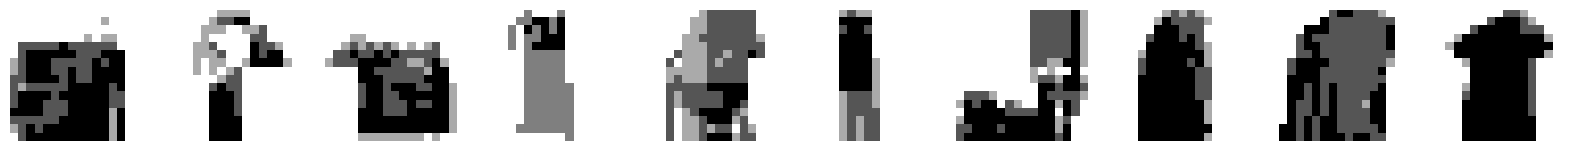

469/469 [==============================] - 15s 31ms/step - loss: 0.3543
Epoch 16/150
469/469 [==============================] - ETA: 0s - loss: 0.3532
Saved to ./output/generated_img_015.png


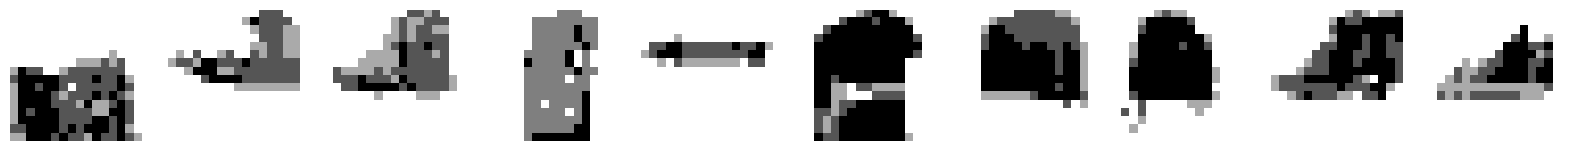

469/469 [==============================] - 15s 33ms/step - loss: 0.3532
Epoch 17/150
467/469 [============================>.] - ETA: 0s - loss: 0.3521
Saved to ./output/generated_img_016.png


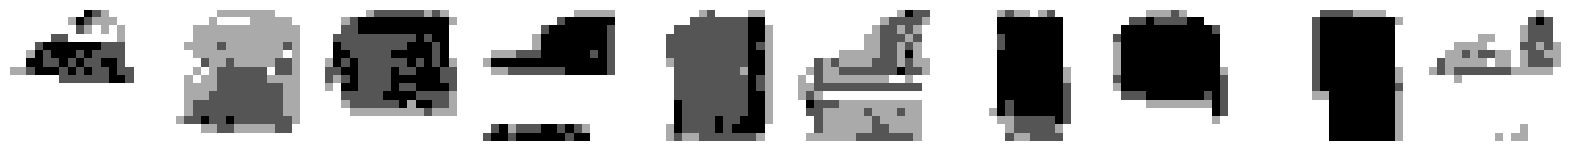

469/469 [==============================] - 15s 32ms/step - loss: 0.3521
Epoch 18/150
466/469 [============================>.] - ETA: 0s - loss: 0.3511
Saved to ./output/generated_img_017.png


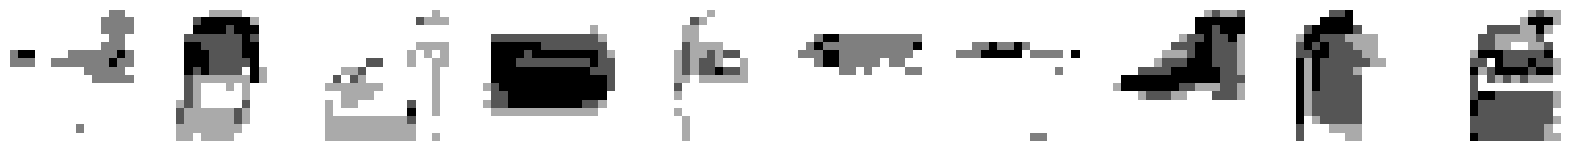

469/469 [==============================] - 15s 32ms/step - loss: 0.3510
Epoch 19/150
468/469 [============================>.] - ETA: 0s - loss: 0.3499
Saved to ./output/generated_img_018.png


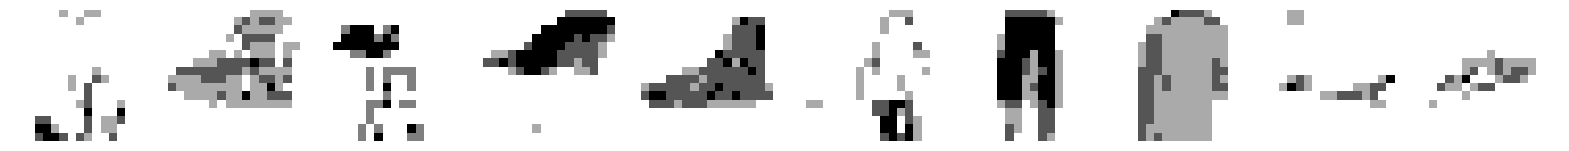

469/469 [==============================] - 15s 32ms/step - loss: 0.3500
Epoch 20/150
467/469 [============================>.] - ETA: 0s - loss: 0.3491
Saved to ./output/generated_img_019.png


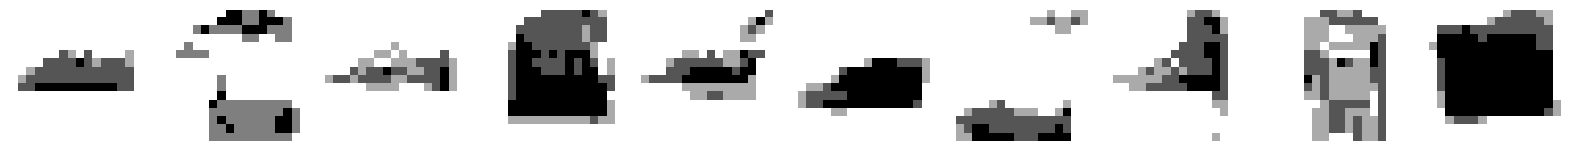

469/469 [==============================] - 15s 32ms/step - loss: 0.3491
Epoch 21/150
468/469 [============================>.] - ETA: 0s - loss: 0.3483
Saved to ./output/generated_img_020.png


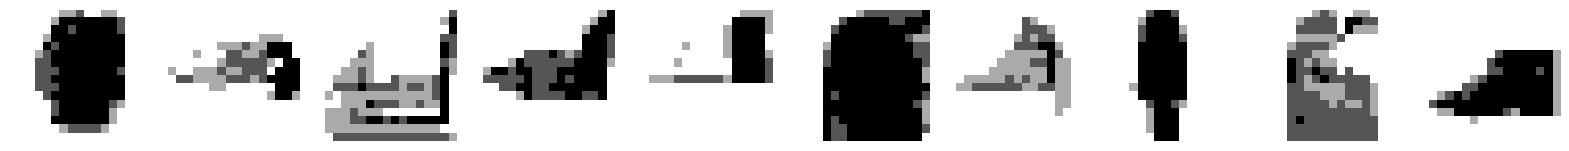

469/469 [==============================] - 15s 32ms/step - loss: 0.3483
Epoch 22/150
466/469 [============================>.] - ETA: 0s - loss: 0.3476
Saved to ./output/generated_img_021.png


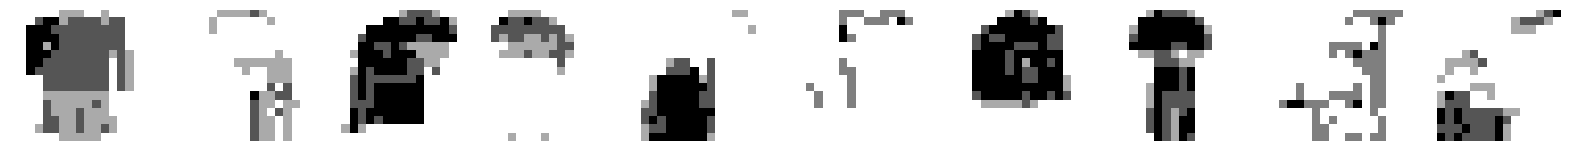

469/469 [==============================] - 15s 32ms/step - loss: 0.3477
Epoch 23/150
466/469 [============================>.] - ETA: 0s - loss: 0.3468
Saved to ./output/generated_img_022.png


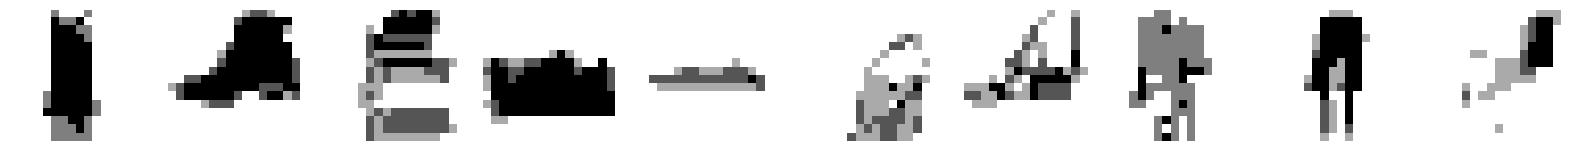

469/469 [==============================] - 15s 33ms/step - loss: 0.3468
Epoch 24/150
467/469 [============================>.] - ETA: 0s - loss: 0.3461
Saved to ./output/generated_img_023.png


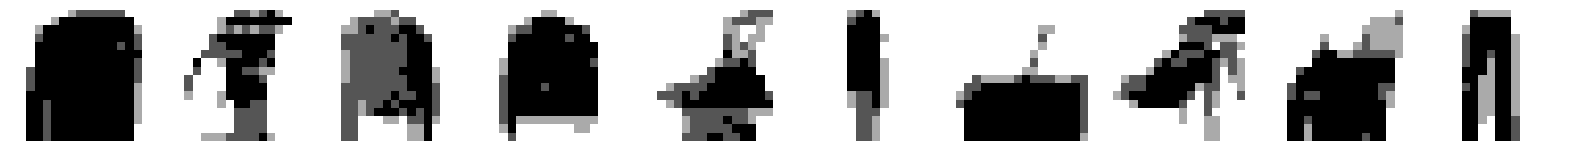

469/469 [==============================] - 15s 32ms/step - loss: 0.3461
Epoch 25/150
467/469 [============================>.] - ETA: 0s - loss: 0.3454
Saved to ./output/generated_img_024.png


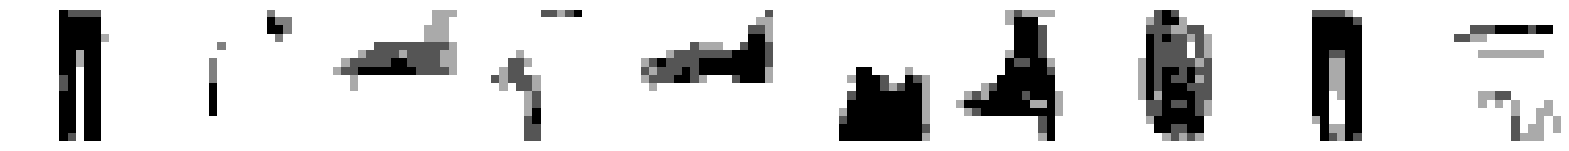

469/469 [==============================] - 15s 32ms/step - loss: 0.3454
Epoch 26/150
468/469 [============================>.] - ETA: 0s - loss: 0.3450
Saved to ./output/generated_img_025.png


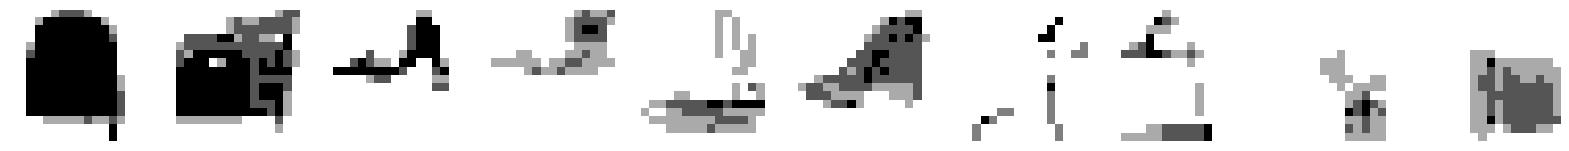

469/469 [==============================] - 15s 32ms/step - loss: 0.3450
Epoch 27/150
469/469 [==============================] - ETA: 0s - loss: 0.3443
Saved to ./output/generated_img_026.png


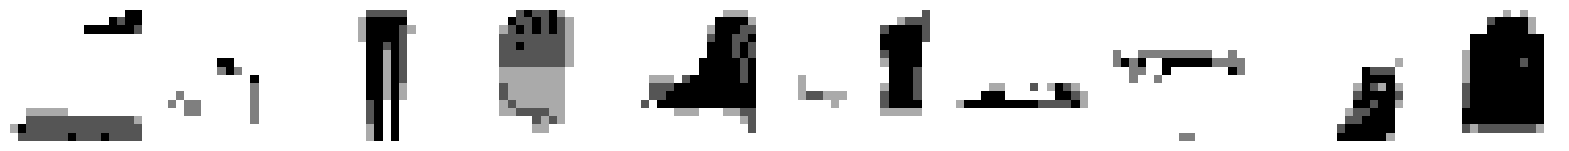

469/469 [==============================] - 15s 32ms/step - loss: 0.3443
Epoch 28/150
467/469 [============================>.] - ETA: 0s - loss: 0.3437
Saved to ./output/generated_img_027.png


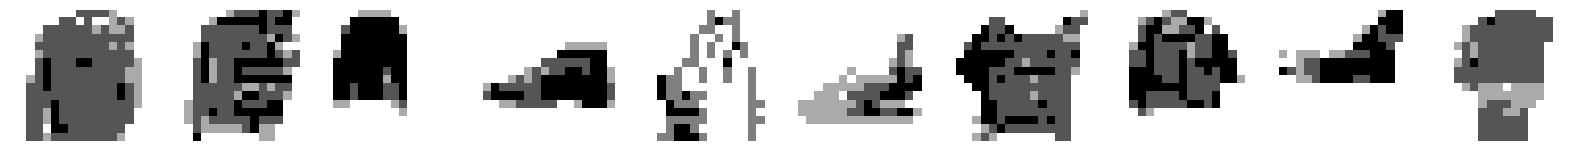

469/469 [==============================] - 15s 33ms/step - loss: 0.3436
Epoch 29/150
466/469 [============================>.] - ETA: 0s - loss: 0.3429
Saved to ./output/generated_img_028.png


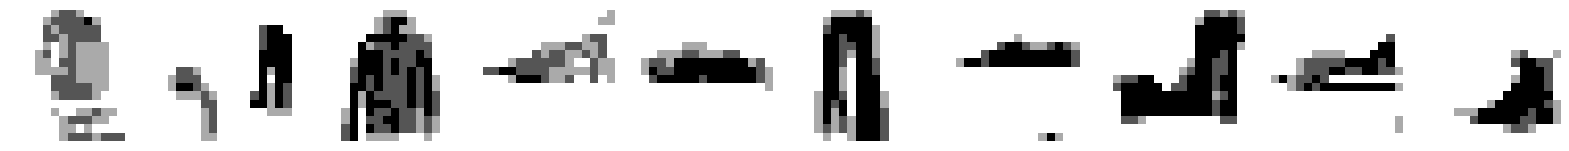

469/469 [==============================] - 15s 32ms/step - loss: 0.3429
Epoch 30/150
467/469 [============================>.] - ETA: 0s - loss: 0.3425
Saved to ./output/generated_img_029.png


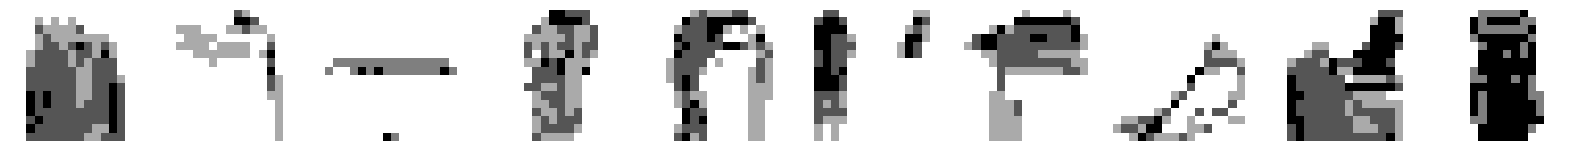

469/469 [==============================] - 15s 33ms/step - loss: 0.3425
Epoch 31/150
467/469 [============================>.] - ETA: 0s - loss: 0.3421
Saved to ./output/generated_img_030.png


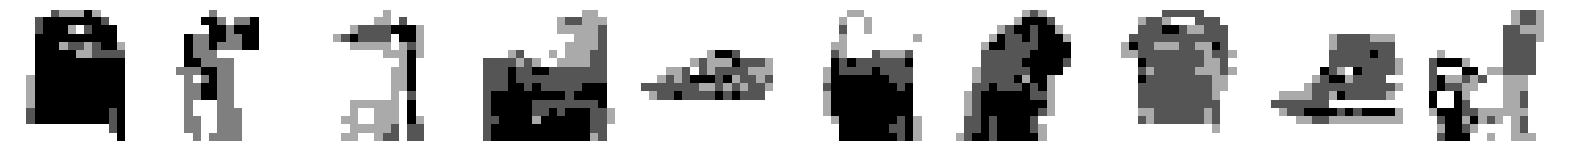

469/469 [==============================] - 15s 32ms/step - loss: 0.3421
Epoch 32/150
468/469 [============================>.] - ETA: 0s - loss: 0.3415
Saved to ./output/generated_img_031.png


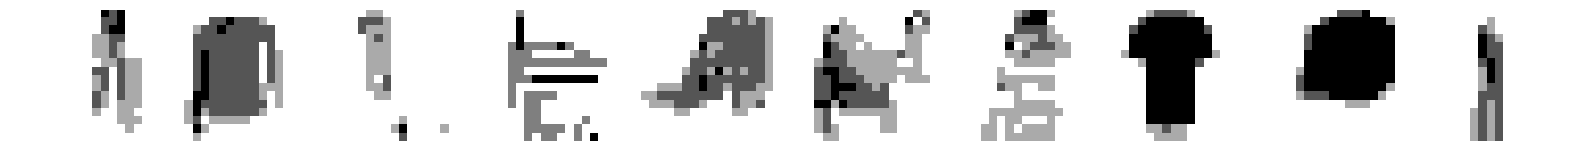

469/469 [==============================] - 16s 33ms/step - loss: 0.3415
Epoch 33/150
466/469 [============================>.] - ETA: 0s - loss: 0.3410
Saved to ./output/generated_img_032.png


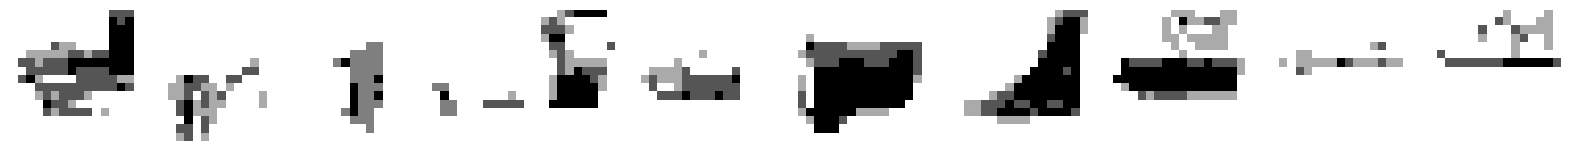

469/469 [==============================] - 15s 32ms/step - loss: 0.3411
Epoch 34/150
468/469 [============================>.] - ETA: 0s - loss: 0.3407
Saved to ./output/generated_img_033.png


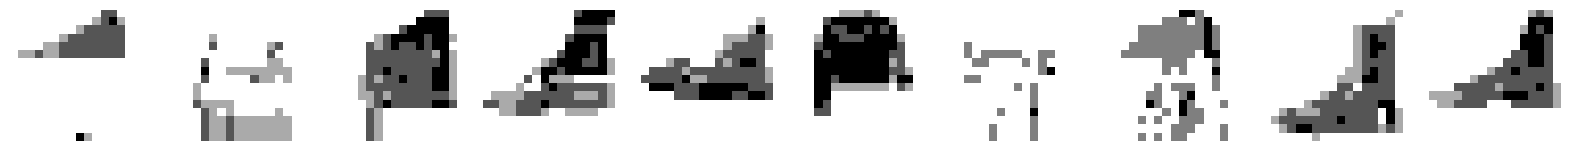

469/469 [==============================] - 15s 33ms/step - loss: 0.3407
Epoch 35/150
468/469 [============================>.] - ETA: 0s - loss: 0.3402
Saved to ./output/generated_img_034.png


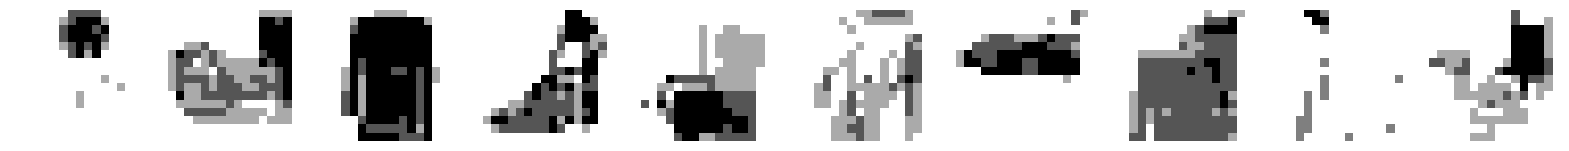

469/469 [==============================] - 15s 32ms/step - loss: 0.3402
Epoch 36/150
467/469 [============================>.] - ETA: 0s - loss: 0.3397
Saved to ./output/generated_img_035.png


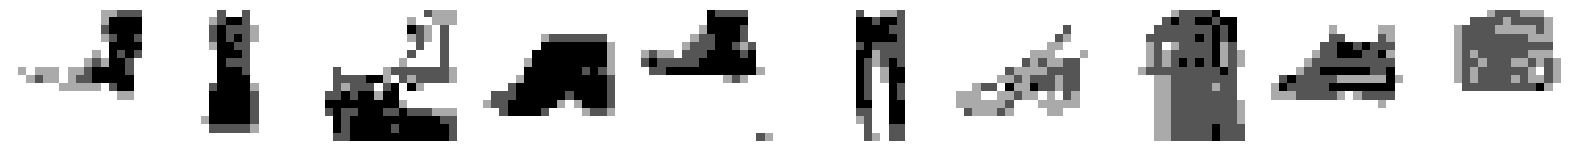

469/469 [==============================] - 15s 33ms/step - loss: 0.3397
Epoch 37/150
467/469 [============================>.] - ETA: 0s - loss: 0.3395
Saved to ./output/generated_img_036.png


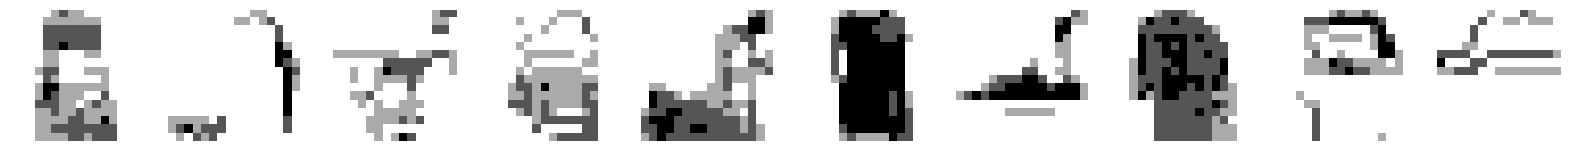

469/469 [==============================] - 15s 32ms/step - loss: 0.3396
Epoch 38/150
466/469 [============================>.] - ETA: 0s - loss: 0.3388
Saved to ./output/generated_img_037.png


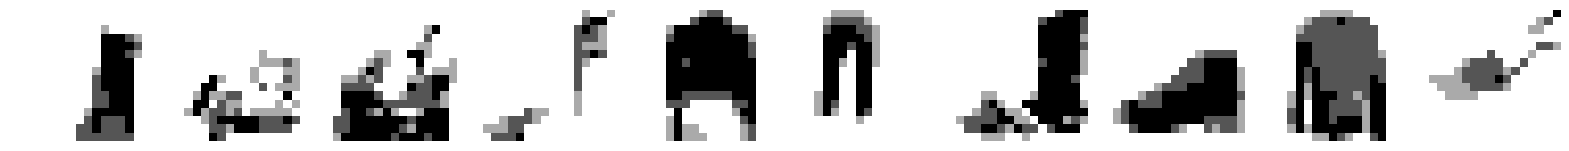

469/469 [==============================] - 15s 33ms/step - loss: 0.3388
Epoch 39/150
466/469 [============================>.] - ETA: 0s - loss: 0.3386
Saved to ./output/generated_img_038.png


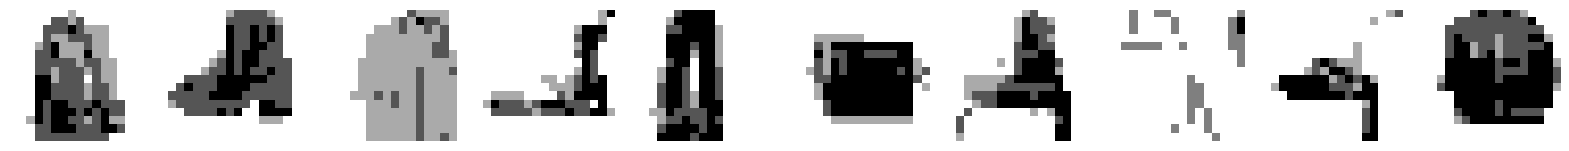

469/469 [==============================] - 15s 32ms/step - loss: 0.3387
Epoch 40/150
467/469 [============================>.] - ETA: 0s - loss: 0.3385
Saved to ./output/generated_img_039.png


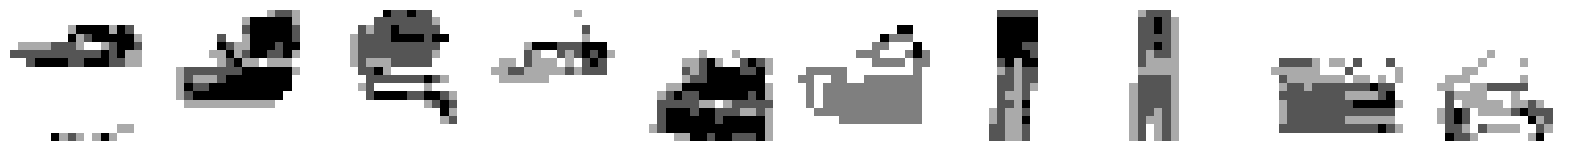

469/469 [==============================] - 15s 32ms/step - loss: 0.3385
Epoch 41/150
466/469 [============================>.] - ETA: 0s - loss: 0.3379
Saved to ./output/generated_img_040.png


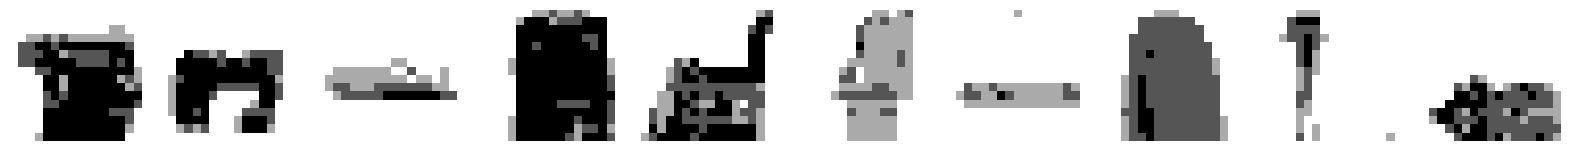

469/469 [==============================] - 15s 33ms/step - loss: 0.3379
Epoch 42/150
468/469 [============================>.] - ETA: 0s - loss: 0.3377
Saved to ./output/generated_img_041.png


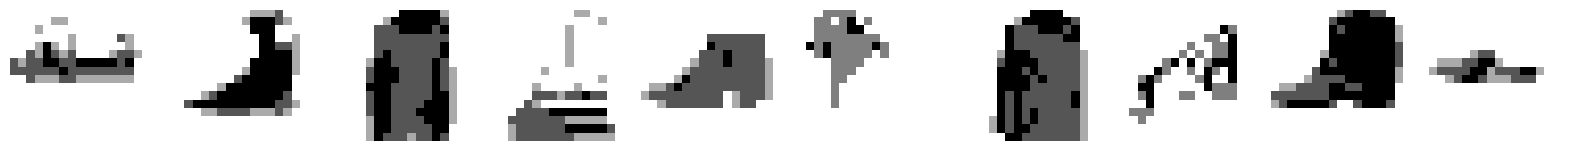

469/469 [==============================] - 15s 32ms/step - loss: 0.3377
Epoch 43/150
468/469 [============================>.] - ETA: 0s - loss: 0.3373
Saved to ./output/generated_img_042.png


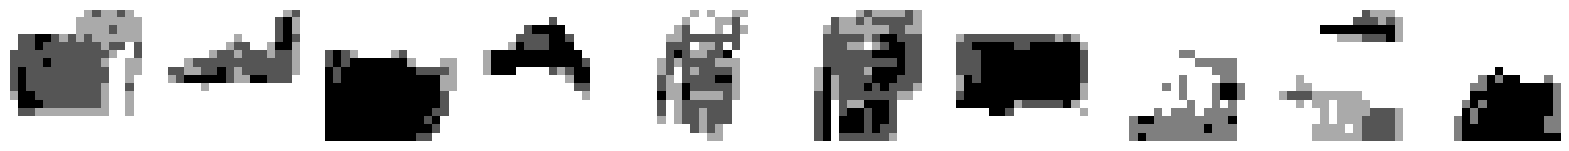

469/469 [==============================] - 15s 33ms/step - loss: 0.3373
Epoch 44/150
466/469 [============================>.] - ETA: 0s - loss: 0.3370
Saved to ./output/generated_img_043.png


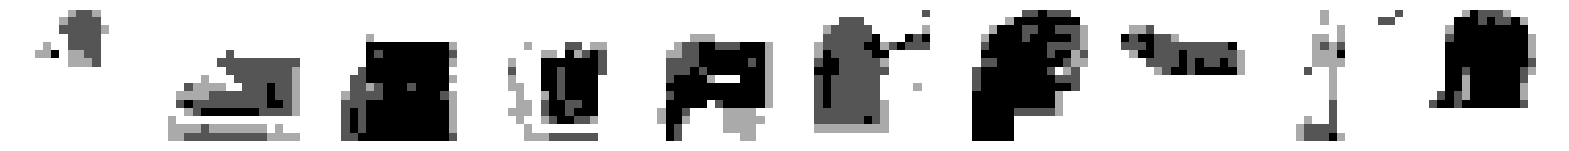

469/469 [==============================] - 15s 33ms/step - loss: 0.3370
Epoch 45/150
467/469 [============================>.] - ETA: 0s - loss: 0.3366
Saved to ./output/generated_img_044.png


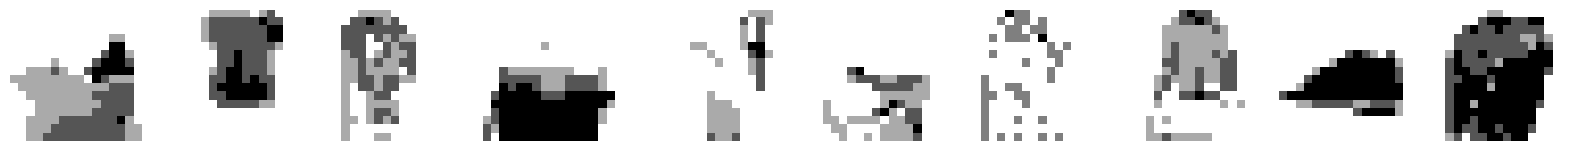

469/469 [==============================] - 15s 33ms/step - loss: 0.3366
Epoch 46/150
468/469 [============================>.] - ETA: 0s - loss: 0.3363
Saved to ./output/generated_img_045.png


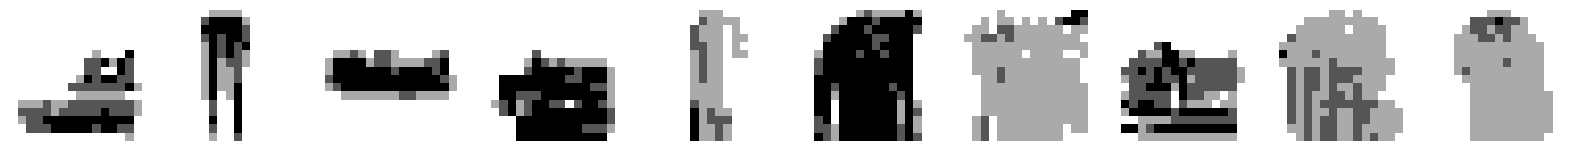

469/469 [==============================] - 15s 33ms/step - loss: 0.3363
Epoch 47/150
467/469 [============================>.] - ETA: 0s - loss: 0.3360
Saved to ./output/generated_img_046.png


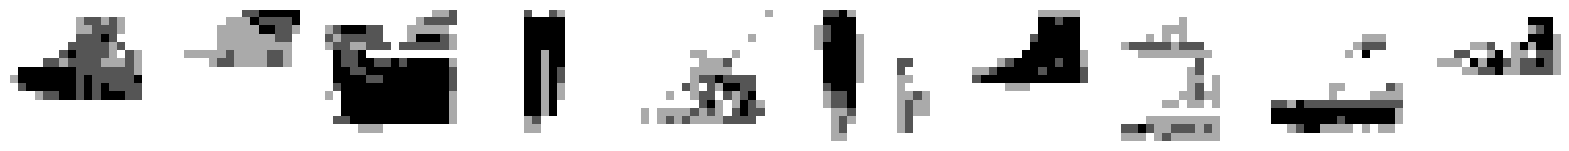

469/469 [==============================] - 15s 32ms/step - loss: 0.3361
Epoch 48/150
468/469 [============================>.] - ETA: 0s - loss: 0.3359
Saved to ./output/generated_img_047.png


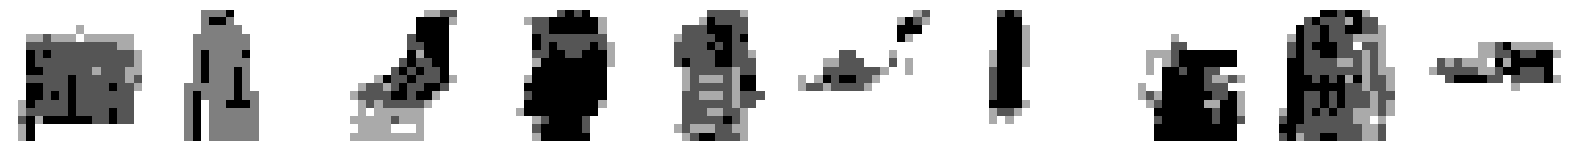

469/469 [==============================] - 16s 33ms/step - loss: 0.3359
Epoch 49/150
468/469 [============================>.] - ETA: 0s - loss: 0.3356
Saved to ./output/generated_img_048.png


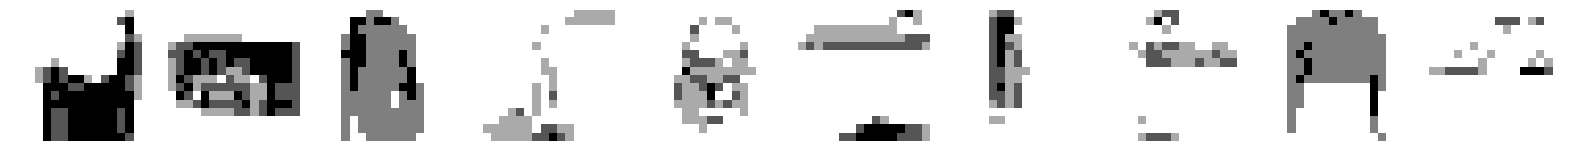

469/469 [==============================] - 15s 32ms/step - loss: 0.3356
Epoch 50/150
468/469 [============================>.] - ETA: 0s - loss: 0.3351
Saved to ./output/generated_img_049.png


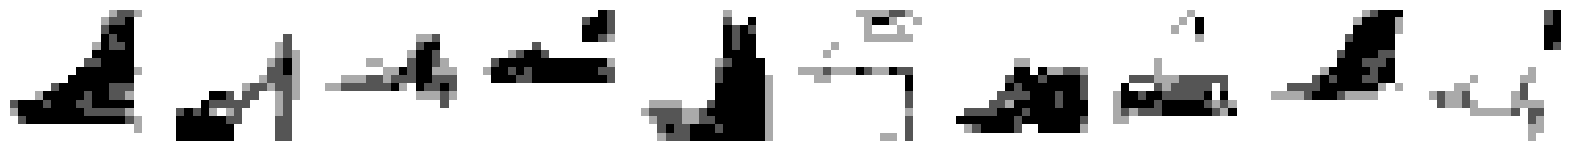

469/469 [==============================] - 16s 33ms/step - loss: 0.3351
Epoch 51/150
466/469 [============================>.] - ETA: 0s - loss: 0.3351
Saved to ./output/generated_img_050.png


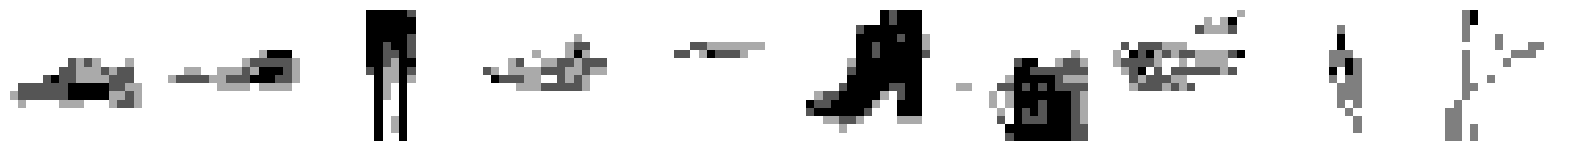

469/469 [==============================] - 15s 32ms/step - loss: 0.3351
Epoch 52/150
468/469 [============================>.] - ETA: 0s - loss: 0.3347
Saved to ./output/generated_img_051.png


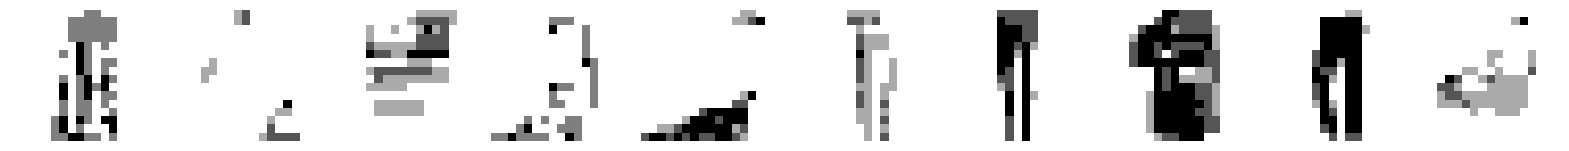

469/469 [==============================] - 16s 33ms/step - loss: 0.3347
Epoch 53/150
467/469 [============================>.] - ETA: 0s - loss: 0.3346
Saved to ./output/generated_img_052.png


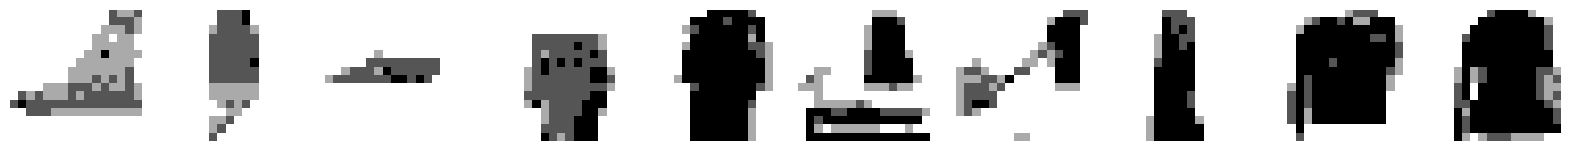

469/469 [==============================] - 15s 32ms/step - loss: 0.3346
Epoch 54/150
467/469 [============================>.] - ETA: 0s - loss: 0.3343
Saved to ./output/generated_img_053.png


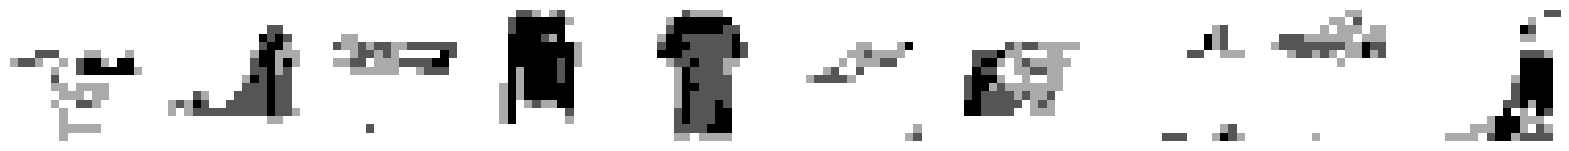

469/469 [==============================] - 16s 33ms/step - loss: 0.3343
Epoch 55/150
467/469 [============================>.] - ETA: 0s - loss: 0.3340
Saved to ./output/generated_img_054.png


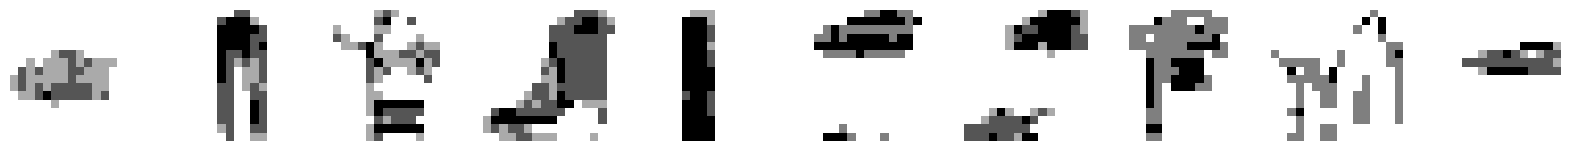

469/469 [==============================] - 15s 32ms/step - loss: 0.3340
Epoch 56/150
468/469 [============================>.] - ETA: 0s - loss: 0.3340
Saved to ./output/generated_img_055.png


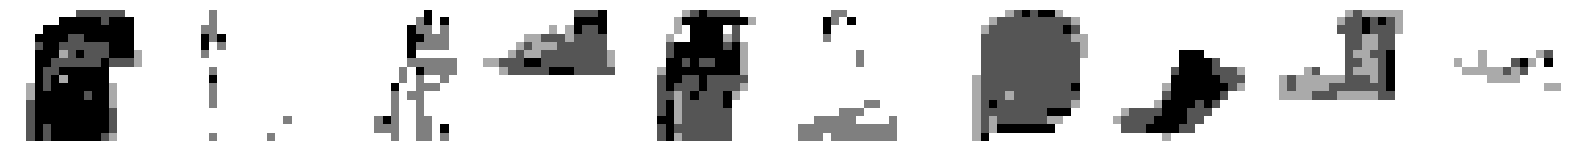

469/469 [==============================] - 15s 33ms/step - loss: 0.3341
Epoch 57/150
466/469 [============================>.] - ETA: 0s - loss: 0.3335
Saved to ./output/generated_img_056.png


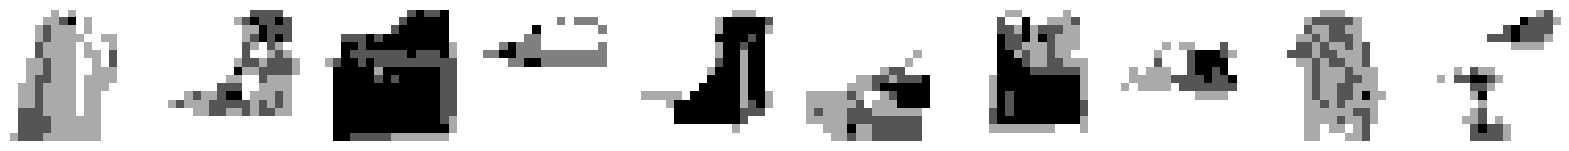

469/469 [==============================] - 15s 33ms/step - loss: 0.3335
Epoch 58/150
467/469 [============================>.] - ETA: 0s - loss: 0.3334
Saved to ./output/generated_img_057.png


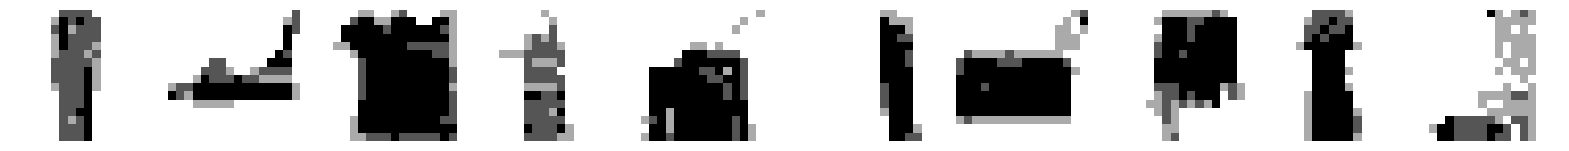

469/469 [==============================] - 16s 33ms/step - loss: 0.3334
Epoch 59/150
468/469 [============================>.] - ETA: 0s - loss: 0.3333
Saved to ./output/generated_img_058.png


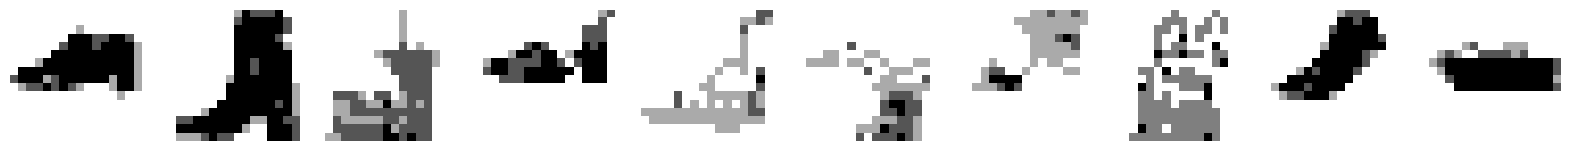

469/469 [==============================] - 15s 33ms/step - loss: 0.3333
Epoch 60/150
467/469 [============================>.] - ETA: 0s - loss: 0.3332
Saved to ./output/generated_img_059.png


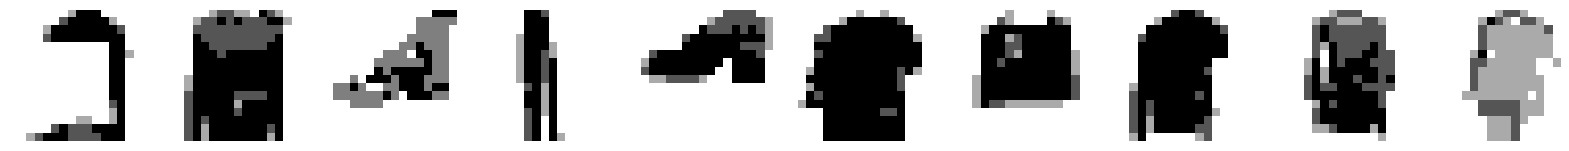

469/469 [==============================] - 15s 32ms/step - loss: 0.3332
Epoch 61/150
466/469 [============================>.] - ETA: 0s - loss: 0.3326
Saved to ./output/generated_img_060.png


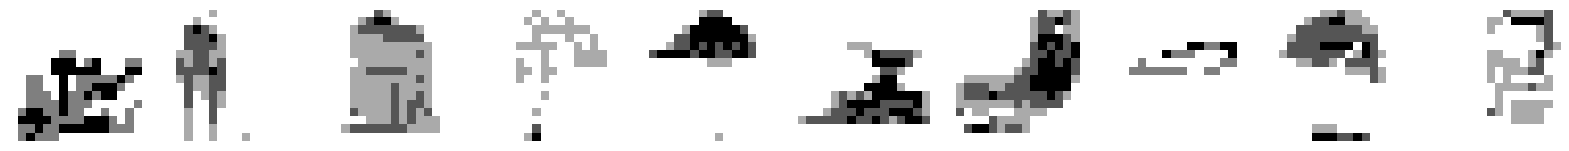

469/469 [==============================] - 16s 33ms/step - loss: 0.3327
Epoch 62/150
466/469 [============================>.] - ETA: 0s - loss: 0.3325
Saved to ./output/generated_img_061.png


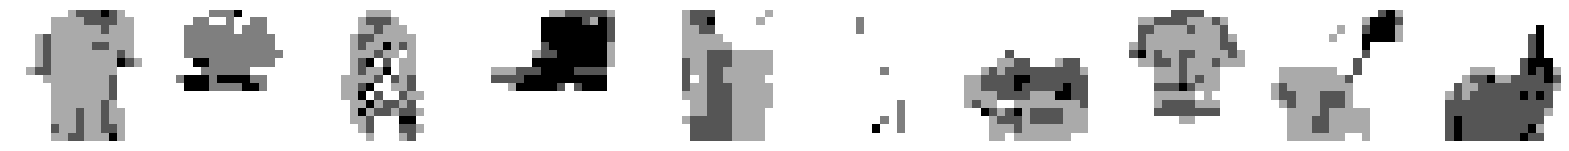

469/469 [==============================] - 15s 32ms/step - loss: 0.3325
Epoch 63/150
467/469 [============================>.] - ETA: 0s - loss: 0.3324
Saved to ./output/generated_img_062.png


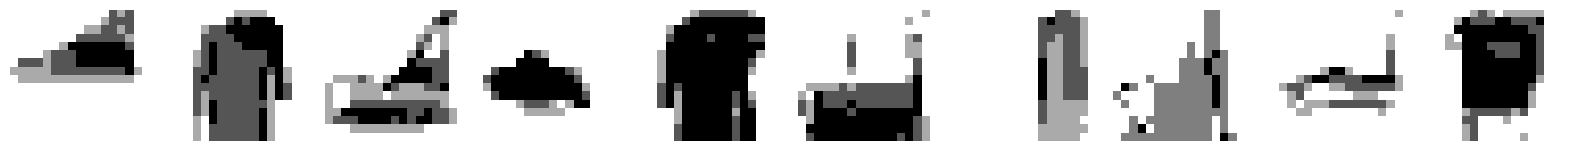

469/469 [==============================] - 16s 33ms/step - loss: 0.3324
Epoch 64/150
466/469 [============================>.] - ETA: 0s - loss: 0.3324
Saved to ./output/generated_img_063.png


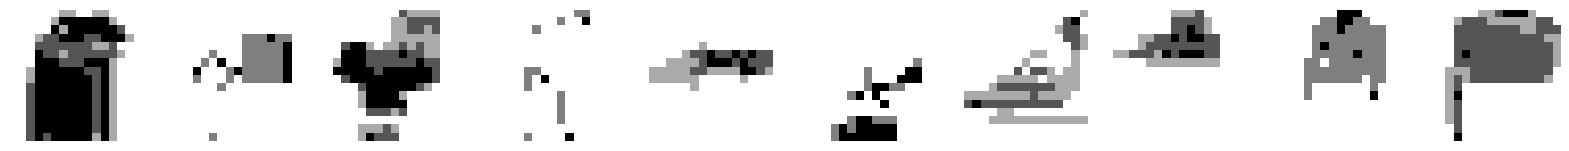

469/469 [==============================] - 15s 32ms/step - loss: 0.3323
Epoch 65/150
466/469 [============================>.] - ETA: 0s - loss: 0.3322
Saved to ./output/generated_img_064.png


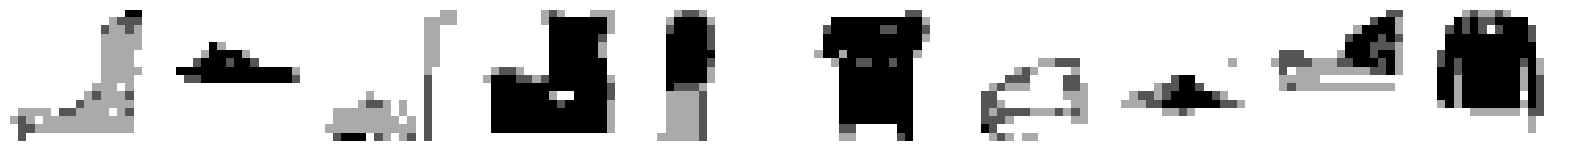

469/469 [==============================] - 15s 32ms/step - loss: 0.3321
Epoch 66/150
468/469 [============================>.] - ETA: 0s - loss: 0.3318
Saved to ./output/generated_img_065.png


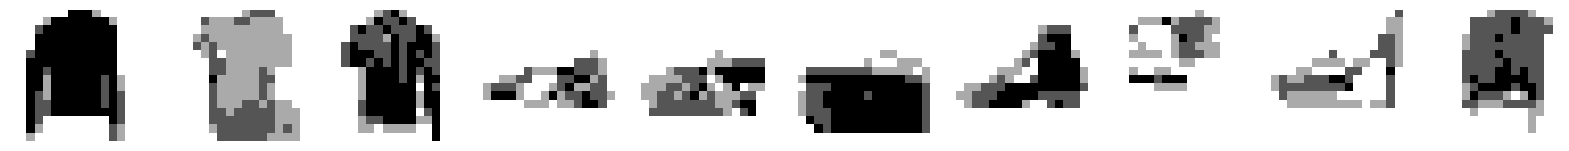

469/469 [==============================] - 15s 33ms/step - loss: 0.3318
Epoch 67/150
467/469 [============================>.] - ETA: 0s - loss: 0.3316
Saved to ./output/generated_img_066.png


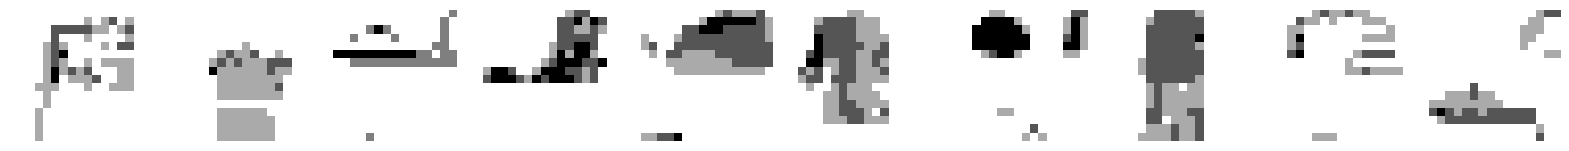

469/469 [==============================] - 15s 32ms/step - loss: 0.3317
Epoch 68/150
466/469 [============================>.] - ETA: 0s - loss: 0.3316
Saved to ./output/generated_img_067.png


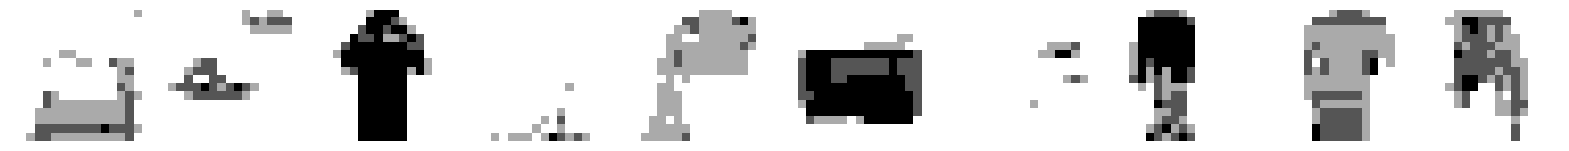

469/469 [==============================] - 16s 33ms/step - loss: 0.3315
Epoch 69/150
468/469 [============================>.] - ETA: 0s - loss: 0.3314
Saved to ./output/generated_img_068.png


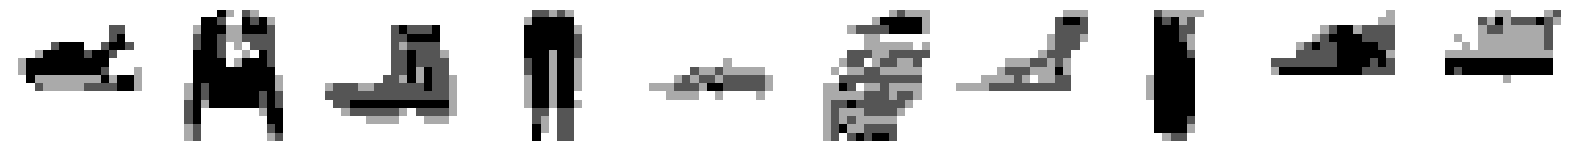

469/469 [==============================] - 15s 32ms/step - loss: 0.3314
Epoch 70/150
466/469 [============================>.] - ETA: 0s - loss: 0.3312
Saved to ./output/generated_img_069.png


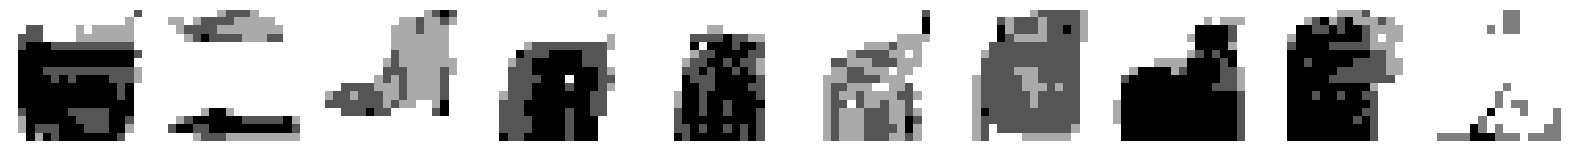

469/469 [==============================] - 16s 33ms/step - loss: 0.3312
Epoch 71/150
468/469 [============================>.] - ETA: 0s - loss: 0.3310
Saved to ./output/generated_img_070.png


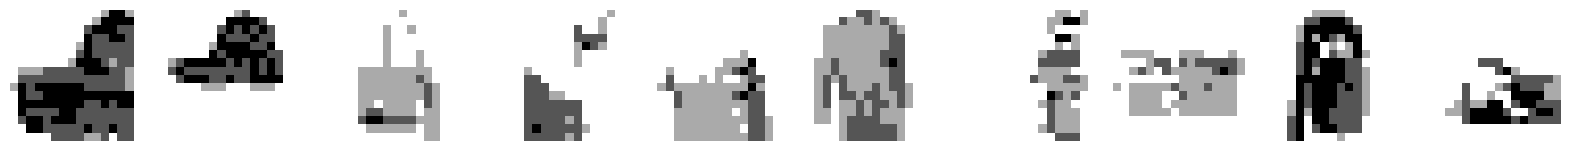

469/469 [==============================] - 15s 32ms/step - loss: 0.3310
Epoch 72/150
467/469 [============================>.] - ETA: 0s - loss: 0.3308
Saved to ./output/generated_img_071.png


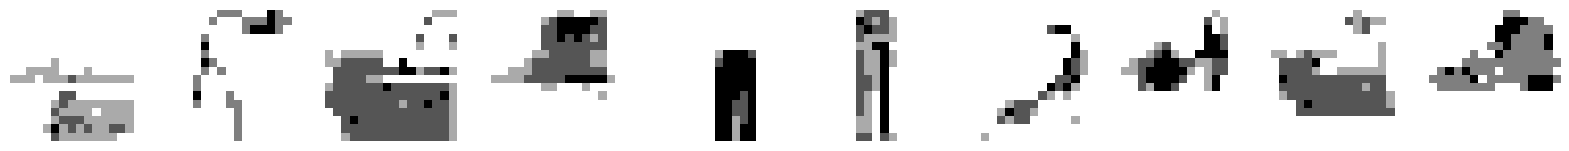

469/469 [==============================] - 16s 33ms/step - loss: 0.3308
Epoch 73/150
468/469 [============================>.] - ETA: 0s - loss: 0.3308
Saved to ./output/generated_img_072.png


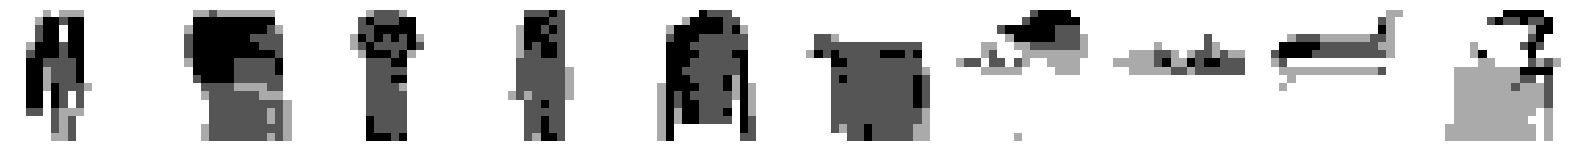

469/469 [==============================] - 15s 32ms/step - loss: 0.3308
Epoch 74/150
468/469 [============================>.] - ETA: 0s - loss: 0.3304
Saved to ./output/generated_img_073.png


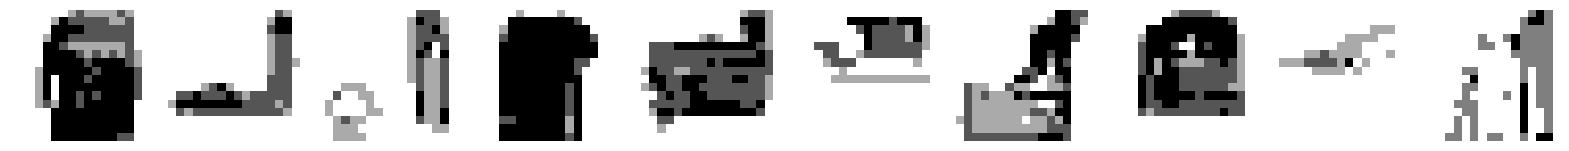

469/469 [==============================] - 15s 32ms/step - loss: 0.3304
Epoch 75/150
468/469 [============================>.] - ETA: 0s - loss: 0.3304
Saved to ./output/generated_img_074.png


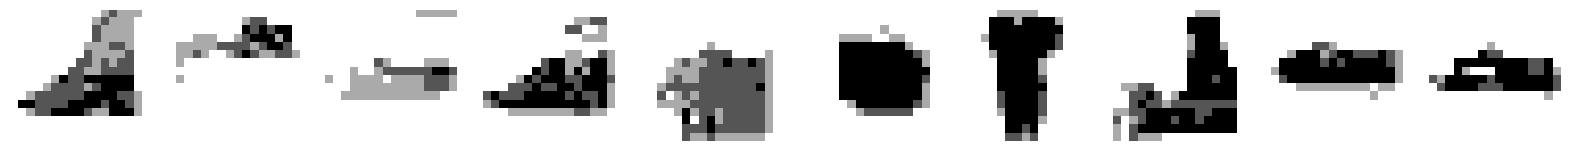

469/469 [==============================] - 15s 33ms/step - loss: 0.3304
Epoch 76/150
469/469 [==============================] - ETA: 0s - loss: 0.3301
Saved to ./output/generated_img_075.png


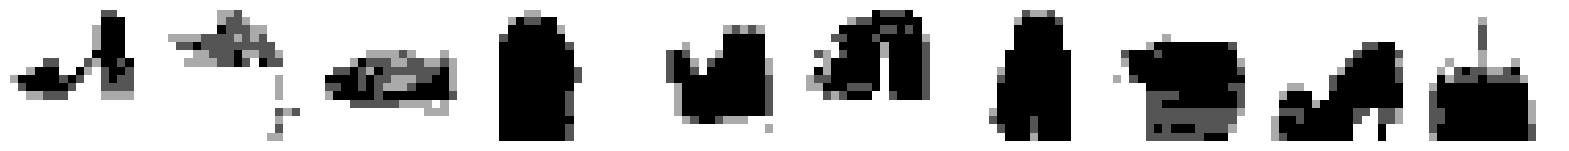

469/469 [==============================] - 15s 32ms/step - loss: 0.3301
Epoch 77/150
466/469 [============================>.] - ETA: 0s - loss: 0.3303
Saved to ./output/generated_img_076.png


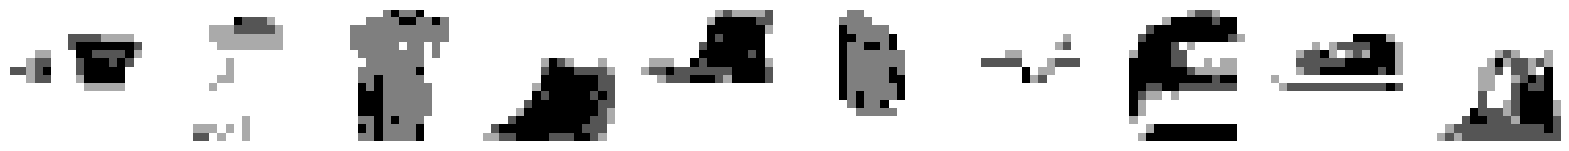

469/469 [==============================] - 15s 32ms/step - loss: 0.3302
Epoch 78/150
468/469 [============================>.] - ETA: 0s - loss: 0.3299
Saved to ./output/generated_img_077.png


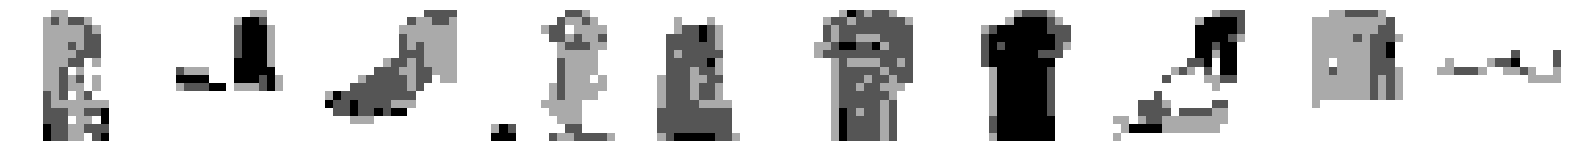

469/469 [==============================] - 15s 32ms/step - loss: 0.3299
Epoch 79/150
468/469 [============================>.] - ETA: 0s - loss: 0.3296
Saved to ./output/generated_img_078.png


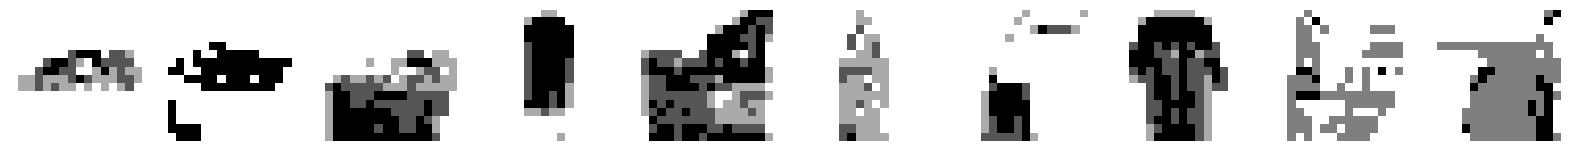

469/469 [==============================] - 15s 33ms/step - loss: 0.3296
Epoch 80/150
467/469 [============================>.] - ETA: 0s - loss: 0.3297
Saved to ./output/generated_img_079.png


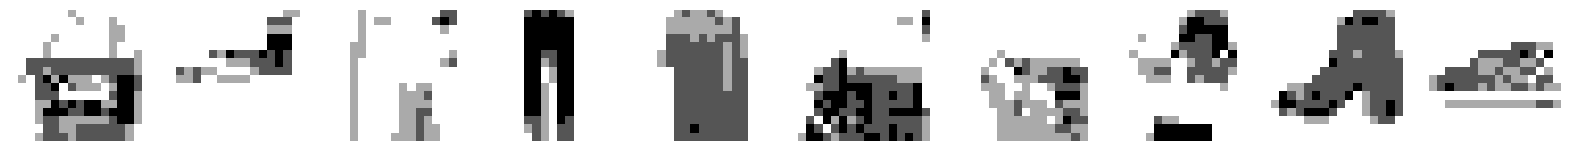

469/469 [==============================] - 15s 32ms/step - loss: 0.3297
Epoch 81/150
468/469 [============================>.] - ETA: 0s - loss: 0.3295
Saved to ./output/generated_img_080.png


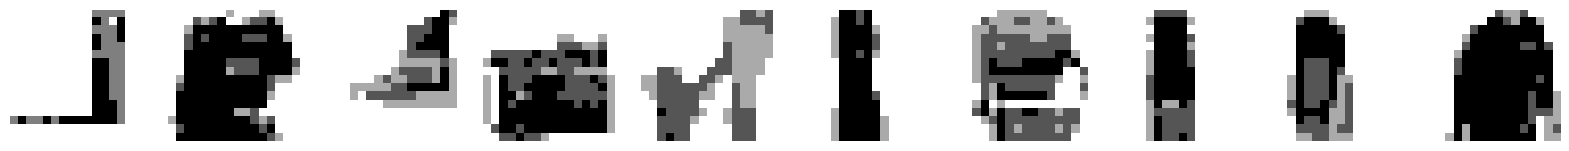

469/469 [==============================] - 15s 33ms/step - loss: 0.3295
Epoch 82/150
467/469 [============================>.] - ETA: 0s - loss: 0.3292
Saved to ./output/generated_img_081.png


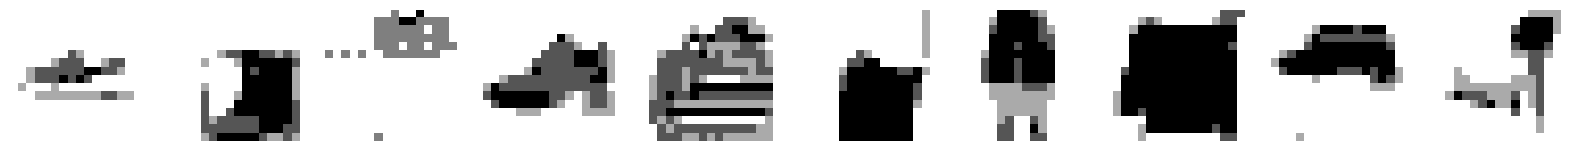

469/469 [==============================] - 15s 32ms/step - loss: 0.3292
Epoch 83/150
469/469 [==============================] - ETA: 0s - loss: 0.3293
Saved to ./output/generated_img_082.png


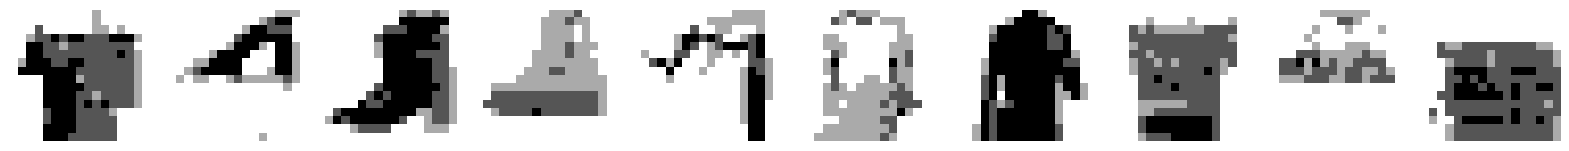

469/469 [==============================] - 15s 33ms/step - loss: 0.3293
Epoch 84/150
468/469 [============================>.] - ETA: 0s - loss: 0.3290
Saved to ./output/generated_img_083.png


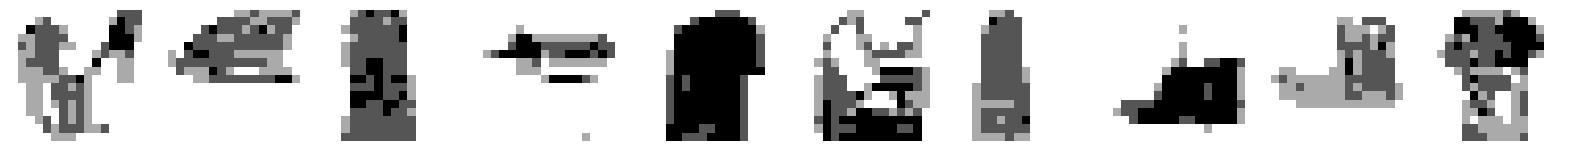

469/469 [==============================] - 15s 32ms/step - loss: 0.3290
Epoch 85/150
468/469 [============================>.] - ETA: 0s - loss: 0.3291
Saved to ./output/generated_img_084.png


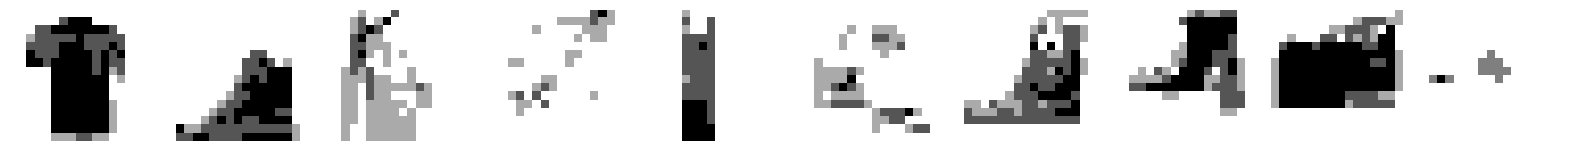

469/469 [==============================] - 15s 32ms/step - loss: 0.3291
Epoch 86/150
468/469 [============================>.] - ETA: 0s - loss: 0.3288
Saved to ./output/generated_img_085.png


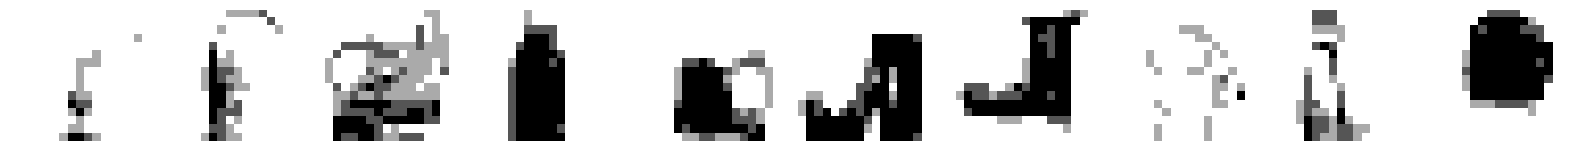

469/469 [==============================] - 15s 32ms/step - loss: 0.3288
Epoch 87/150
466/469 [============================>.] - ETA: 0s - loss: 0.3287
Saved to ./output/generated_img_086.png


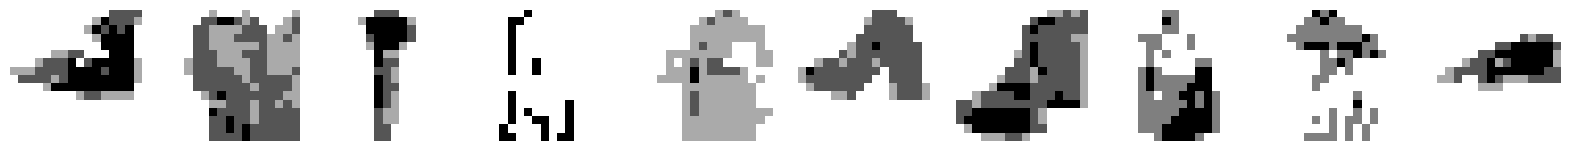

469/469 [==============================] - 15s 32ms/step - loss: 0.3287
Epoch 88/150
467/469 [============================>.] - ETA: 0s - loss: 0.3286
Saved to ./output/generated_img_087.png


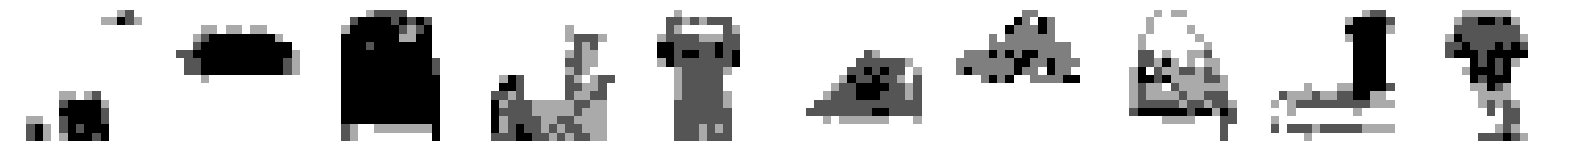

469/469 [==============================] - 15s 32ms/step - loss: 0.3286
Epoch 89/150
466/469 [============================>.] - ETA: 0s - loss: 0.3286
Saved to ./output/generated_img_088.png


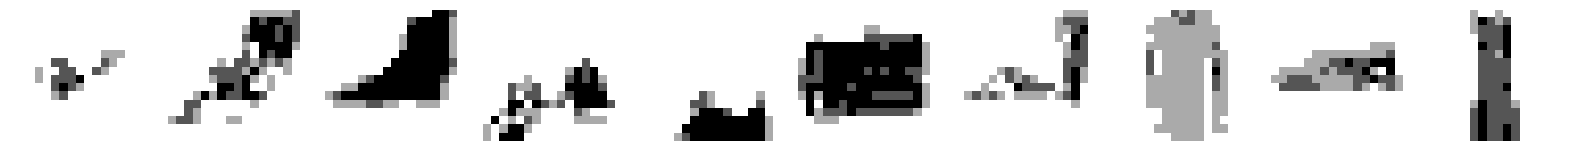

469/469 [==============================] - 15s 32ms/step - loss: 0.3286
Epoch 90/150
468/469 [============================>.] - ETA: 0s - loss: 0.3283
Saved to ./output/generated_img_089.png


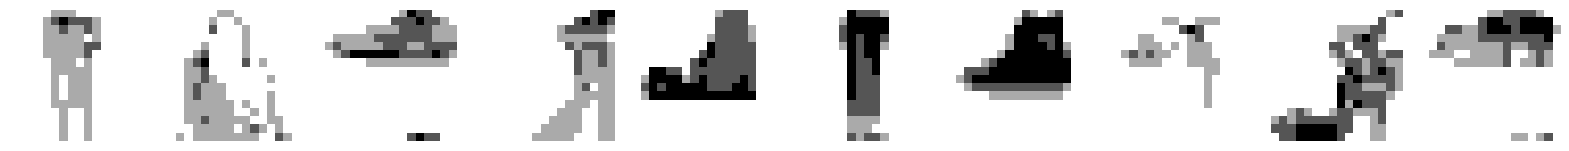

469/469 [==============================] - 15s 33ms/step - loss: 0.3283
Epoch 91/150
468/469 [============================>.] - ETA: 0s - loss: 0.3281
Saved to ./output/generated_img_090.png


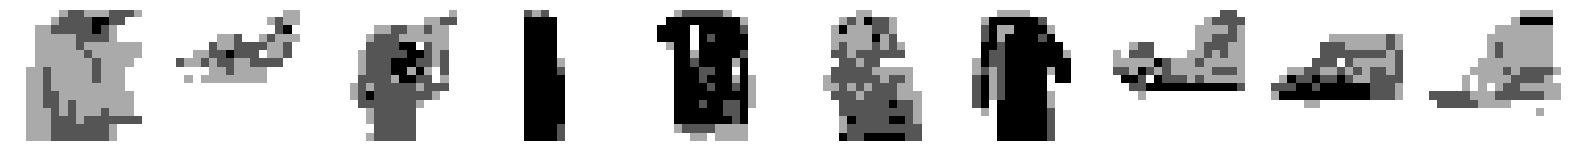

469/469 [==============================] - 15s 32ms/step - loss: 0.3281
Epoch 92/150
468/469 [============================>.] - ETA: 0s - loss: 0.3279
Saved to ./output/generated_img_091.png


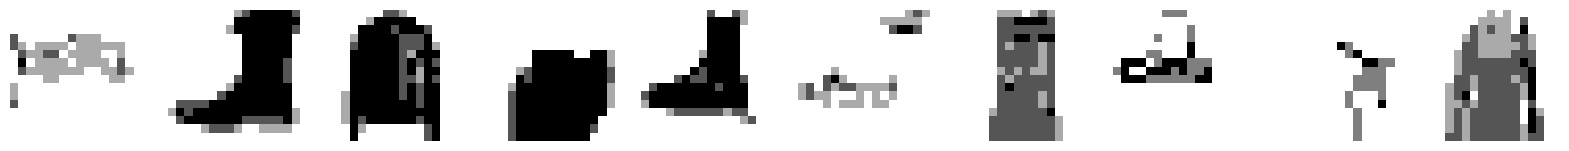

469/469 [==============================] - 15s 32ms/step - loss: 0.3280
Epoch 93/150
466/469 [============================>.] - ETA: 0s - loss: 0.3279
Saved to ./output/generated_img_092.png


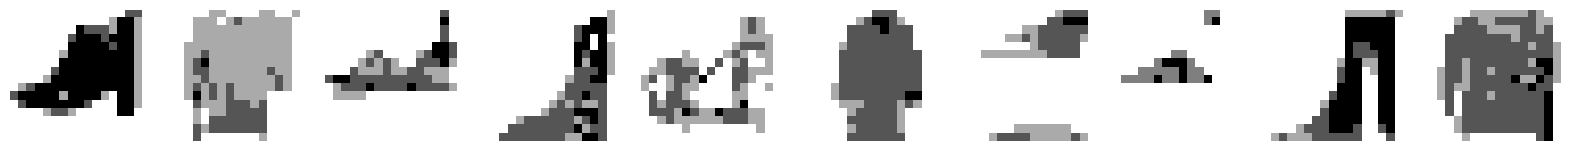

469/469 [==============================] - 15s 32ms/step - loss: 0.3280
Epoch 94/150
467/469 [============================>.] - ETA: 0s - loss: 0.3278
Saved to ./output/generated_img_093.png


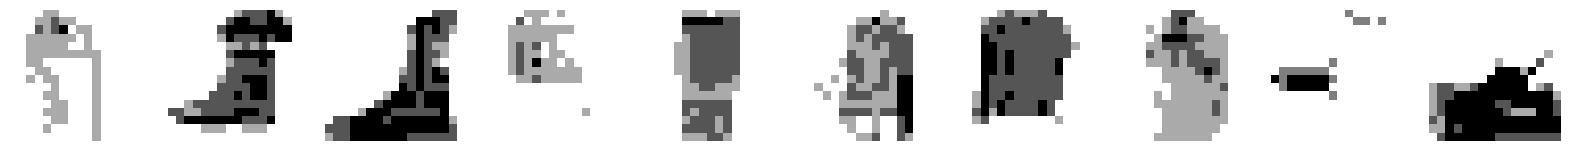

469/469 [==============================] - 15s 32ms/step - loss: 0.3278
Epoch 95/150
469/469 [==============================] - ETA: 0s - loss: 0.3278
Saved to ./output/generated_img_094.png


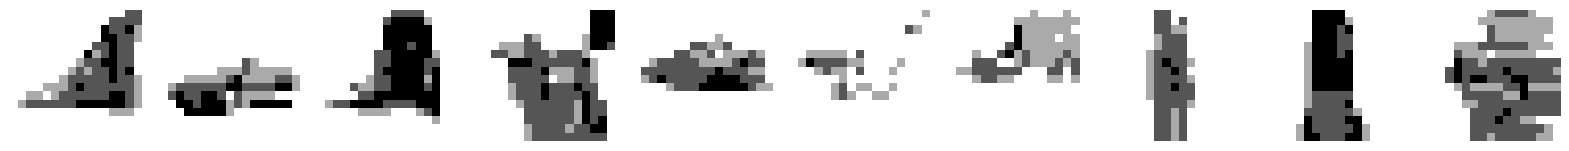

469/469 [==============================] - 15s 32ms/step - loss: 0.3278
Epoch 96/150
466/469 [============================>.] - ETA: 0s - loss: 0.3276
Saved to ./output/generated_img_095.png


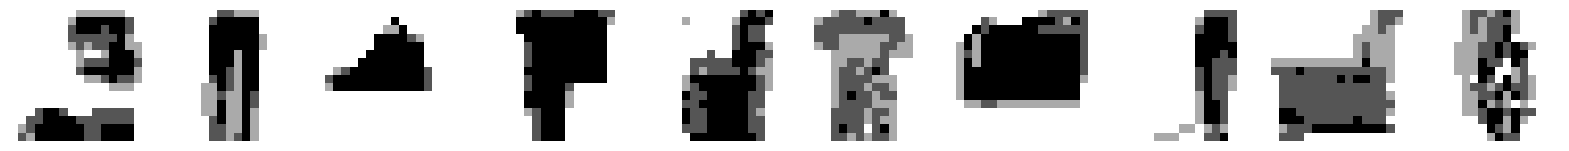

469/469 [==============================] - 15s 32ms/step - loss: 0.3276
Epoch 97/150
467/469 [============================>.] - ETA: 0s - loss: 0.3275
Saved to ./output/generated_img_096.png


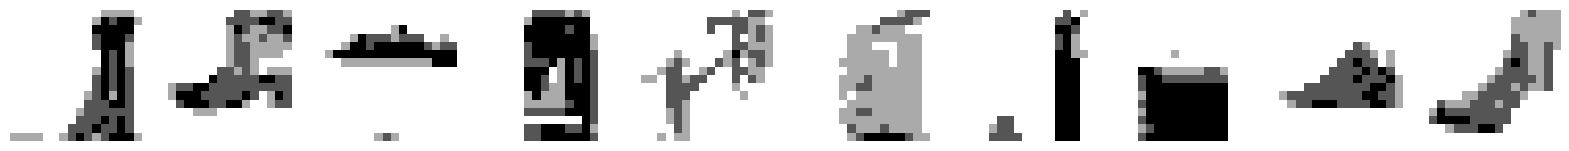

469/469 [==============================] - 15s 32ms/step - loss: 0.3274
Epoch 98/150
467/469 [============================>.] - ETA: 0s - loss: 0.3273
Saved to ./output/generated_img_097.png


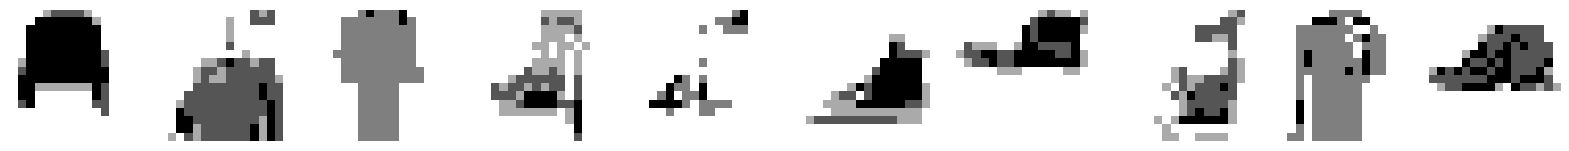

469/469 [==============================] - 15s 31ms/step - loss: 0.3273
Epoch 99/150
468/469 [============================>.] - ETA: 0s - loss: 0.3273
Saved to ./output/generated_img_098.png


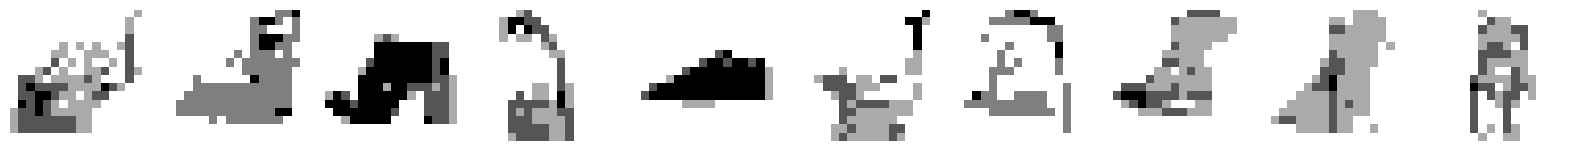

469/469 [==============================] - 15s 33ms/step - loss: 0.3273
Epoch 100/150
469/469 [==============================] - ETA: 0s - loss: 0.3272
Saved to ./output/generated_img_099.png


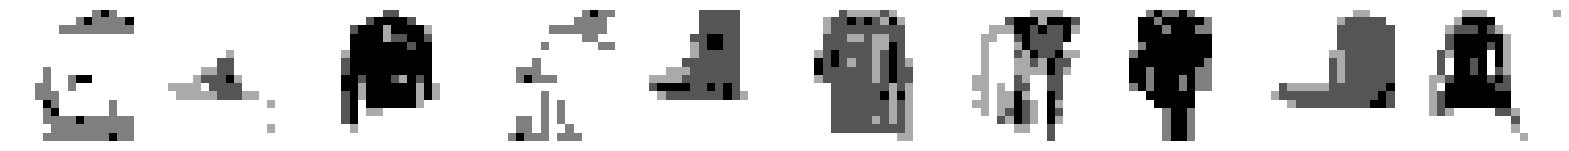

469/469 [==============================] - 15s 31ms/step - loss: 0.3272
Epoch 101/150
468/469 [============================>.] - ETA: 0s - loss: 0.3271
Saved to ./output/generated_img_100.png


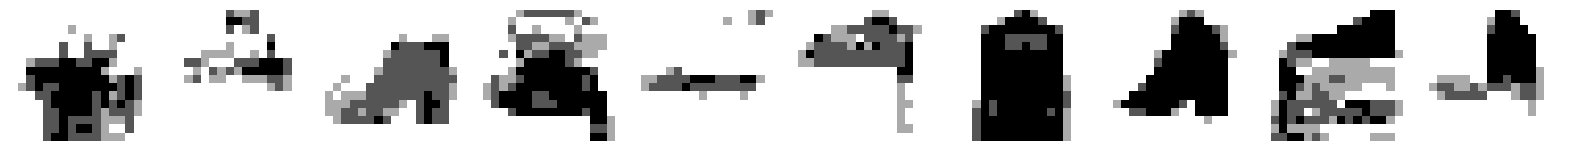

469/469 [==============================] - 15s 32ms/step - loss: 0.3271
Epoch 102/150
467/469 [============================>.] - ETA: 0s - loss: 0.3269
Saved to ./output/generated_img_101.png


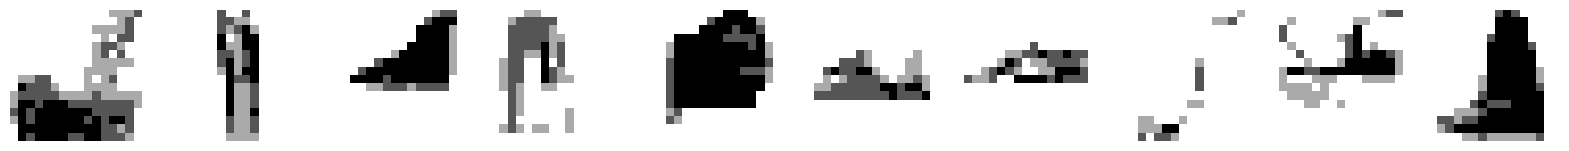

469/469 [==============================] - 15s 31ms/step - loss: 0.3269
Epoch 103/150
468/469 [============================>.] - ETA: 0s - loss: 0.3267
Saved to ./output/generated_img_102.png


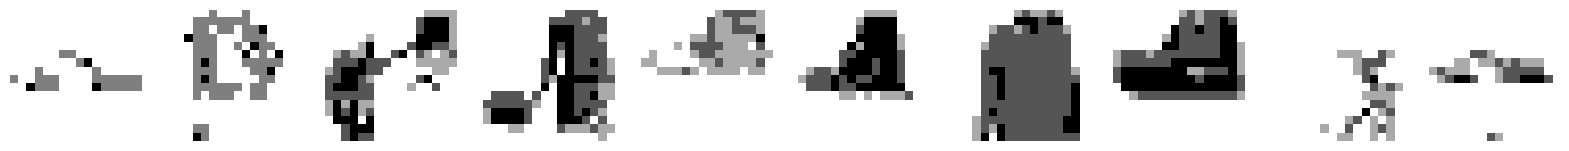

469/469 [==============================] - 15s 33ms/step - loss: 0.3267
Epoch 104/150
468/469 [============================>.] - ETA: 0s - loss: 0.3268
Saved to ./output/generated_img_103.png


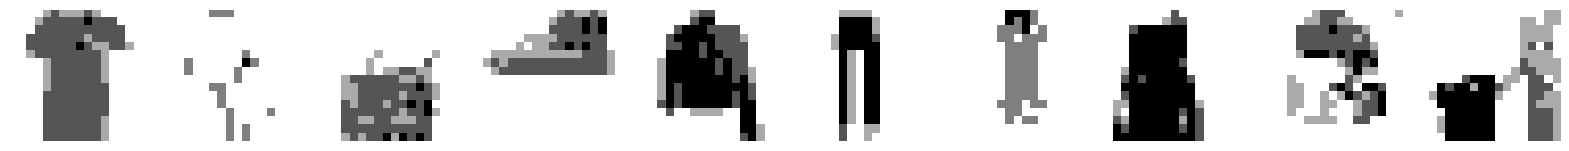

469/469 [==============================] - 15s 31ms/step - loss: 0.3269
Epoch 105/150
469/469 [==============================] - ETA: 0s - loss: 0.3267
Saved to ./output/generated_img_104.png


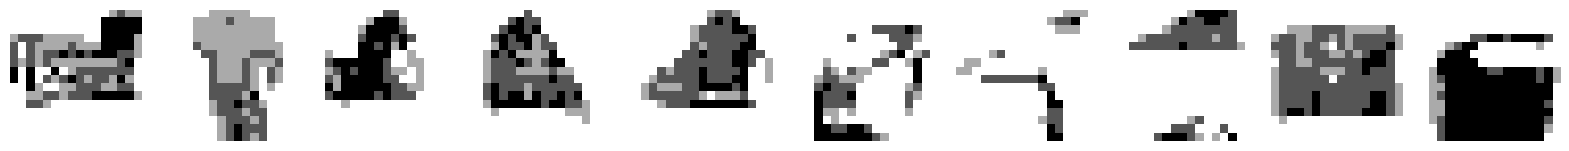

469/469 [==============================] - 15s 32ms/step - loss: 0.3267
Epoch 106/150
467/469 [============================>.] - ETA: 0s - loss: 0.3265
Saved to ./output/generated_img_105.png


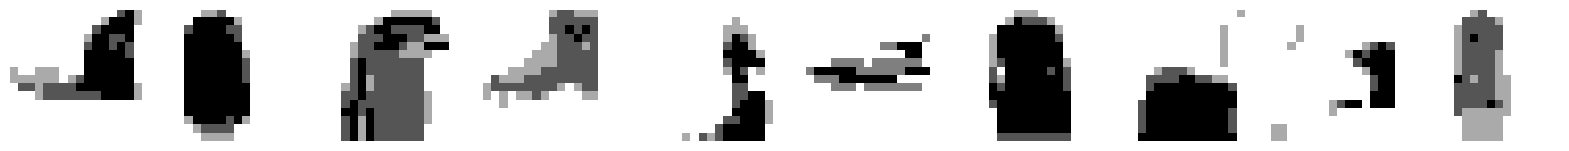

469/469 [==============================] - 15s 32ms/step - loss: 0.3265
Epoch 107/150
467/469 [============================>.] - ETA: 0s - loss: 0.3262
Saved to ./output/generated_img_106.png


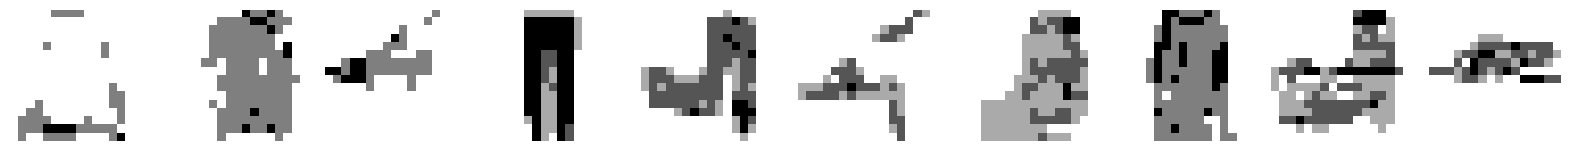

469/469 [==============================] - 15s 32ms/step - loss: 0.3263
Epoch 108/150
468/469 [============================>.] - ETA: 0s - loss: 0.3264
Saved to ./output/generated_img_107.png


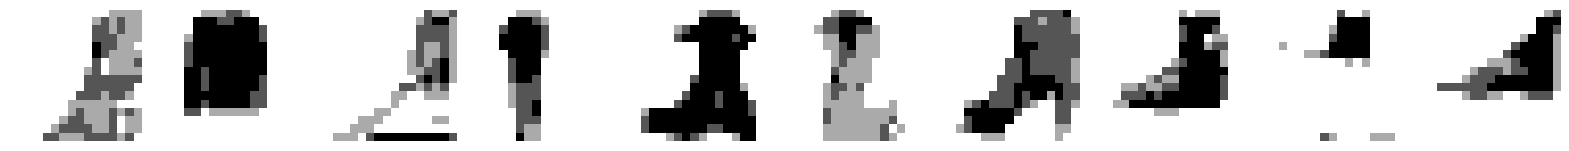

469/469 [==============================] - 15s 32ms/step - loss: 0.3264
Epoch 109/150
466/469 [============================>.] - ETA: 0s - loss: 0.3263
Saved to ./output/generated_img_108.png


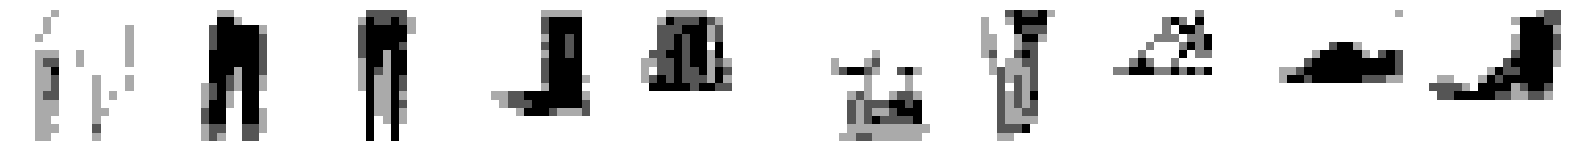

469/469 [==============================] - 15s 31ms/step - loss: 0.3263
Epoch 110/150
469/469 [==============================] - ETA: 0s - loss: 0.3262
Saved to ./output/generated_img_109.png


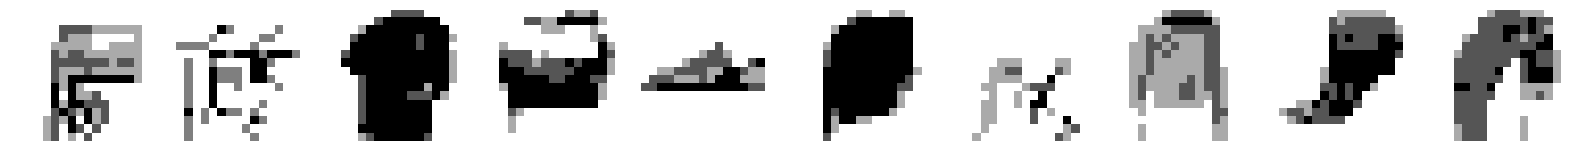

469/469 [==============================] - 15s 32ms/step - loss: 0.3262
Epoch 111/150
466/469 [============================>.] - ETA: 0s - loss: 0.3259
Saved to ./output/generated_img_110.png


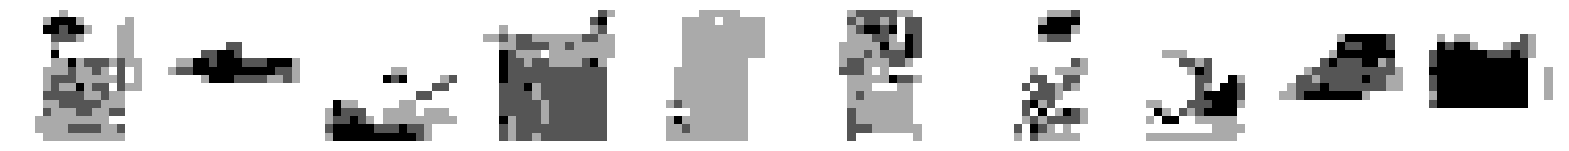

469/469 [==============================] - 15s 32ms/step - loss: 0.3259
Epoch 112/150
467/469 [============================>.] - ETA: 0s - loss: 0.3260
Saved to ./output/generated_img_111.png


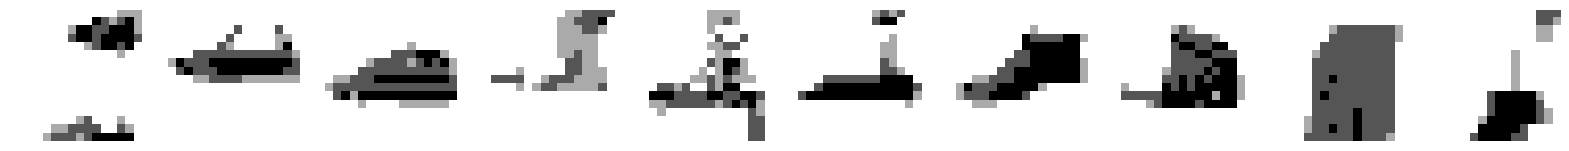

469/469 [==============================] - 15s 32ms/step - loss: 0.3260
Epoch 113/150
466/469 [============================>.] - ETA: 0s - loss: 0.3258
Saved to ./output/generated_img_112.png


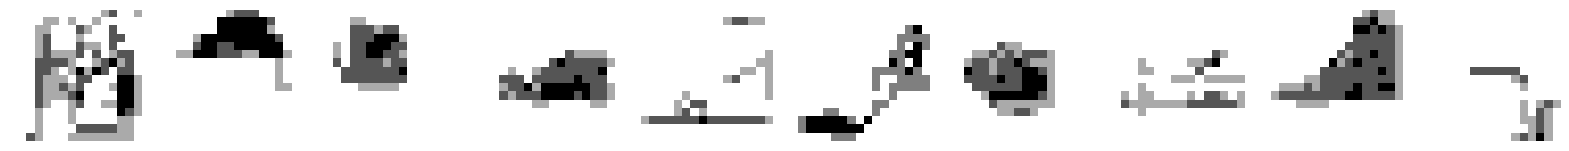

469/469 [==============================] - 15s 31ms/step - loss: 0.3258
Epoch 114/150
468/469 [============================>.] - ETA: 0s - loss: 0.3259
Saved to ./output/generated_img_113.png


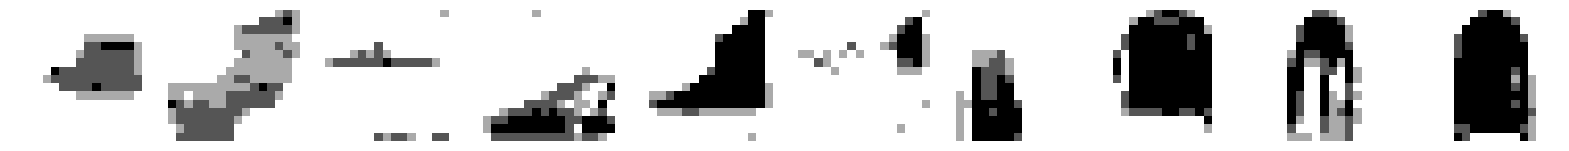

469/469 [==============================] - 15s 32ms/step - loss: 0.3259
Epoch 115/150
467/469 [============================>.] - ETA: 0s - loss: 0.3256
Saved to ./output/generated_img_114.png


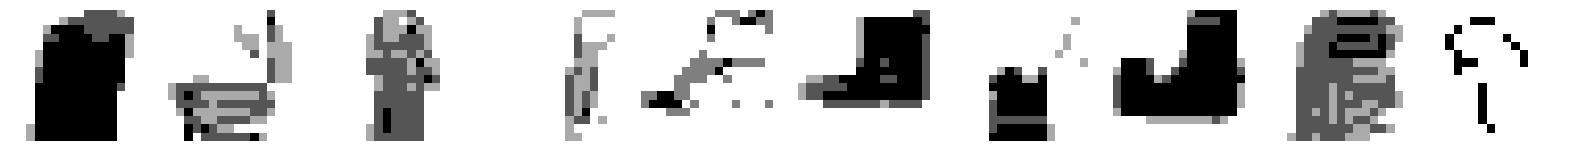

469/469 [==============================] - 15s 32ms/step - loss: 0.3256
Epoch 116/150
466/469 [============================>.] - ETA: 0s - loss: 0.3255
Saved to ./output/generated_img_115.png


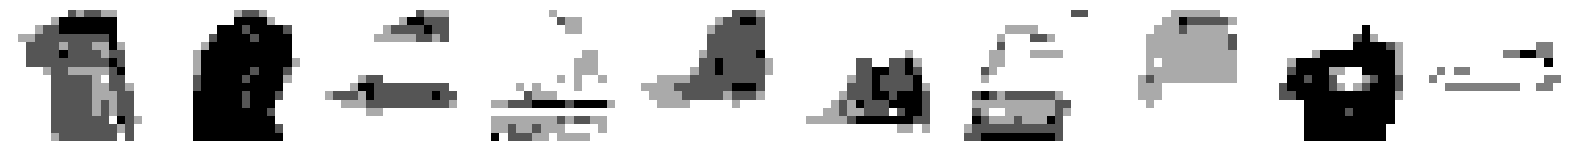

469/469 [==============================] - 15s 32ms/step - loss: 0.3255
Epoch 117/150
469/469 [==============================] - ETA: 0s - loss: 0.3254
Saved to ./output/generated_img_116.png


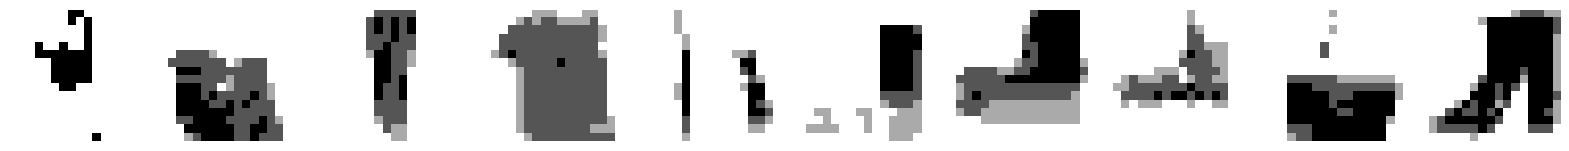

469/469 [==============================] - 15s 32ms/step - loss: 0.3254
Epoch 118/150
468/469 [============================>.] - ETA: 0s - loss: 0.3254
Saved to ./output/generated_img_117.png


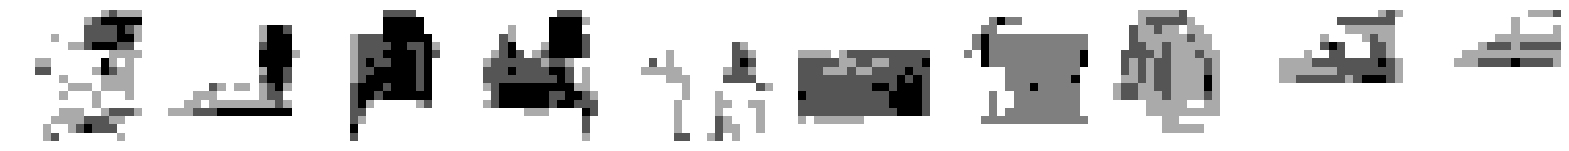

469/469 [==============================] - 15s 31ms/step - loss: 0.3254
Epoch 119/150
467/469 [============================>.] - ETA: 0s - loss: 0.3253
Saved to ./output/generated_img_118.png


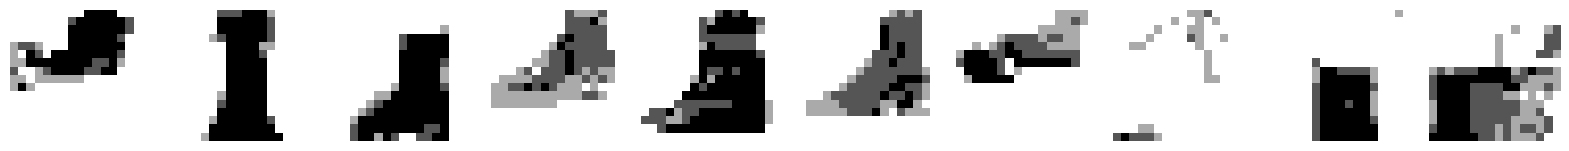

469/469 [==============================] - 15s 32ms/step - loss: 0.3254
Epoch 120/150
469/469 [==============================] - ETA: 0s - loss: 0.3253
Saved to ./output/generated_img_119.png


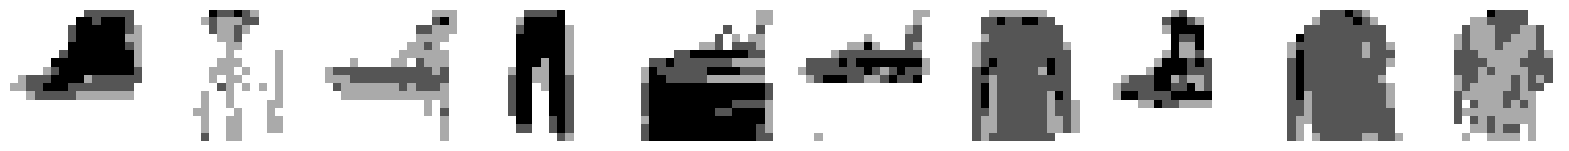

469/469 [==============================] - 15s 31ms/step - loss: 0.3253
Epoch 121/150
467/469 [============================>.] - ETA: 0s - loss: 0.3252
Saved to ./output/generated_img_120.png


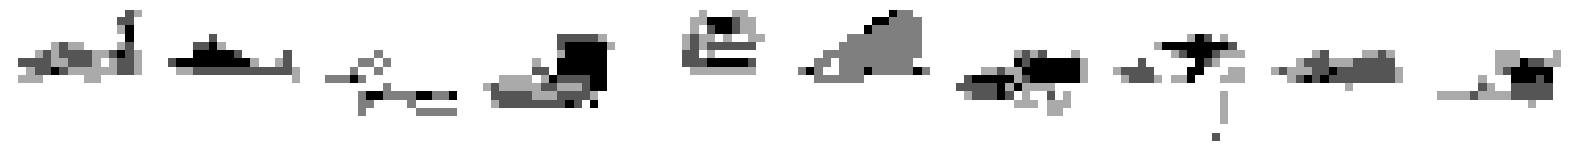

469/469 [==============================] - 15s 32ms/step - loss: 0.3252
Epoch 122/150
468/469 [============================>.] - ETA: 0s - loss: 0.3250
Saved to ./output/generated_img_121.png


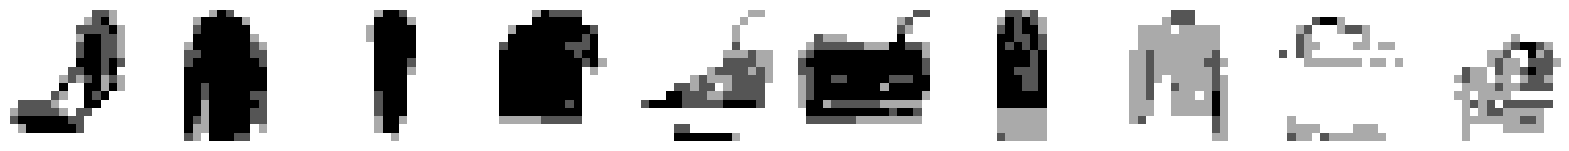

469/469 [==============================] - 15s 31ms/step - loss: 0.3250
Epoch 123/150
468/469 [============================>.] - ETA: 0s - loss: 0.3248
Saved to ./output/generated_img_122.png


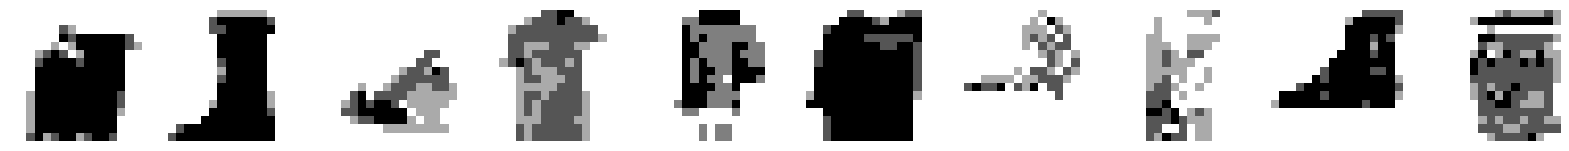

469/469 [==============================] - 15s 32ms/step - loss: 0.3249
Epoch 124/150
468/469 [============================>.] - ETA: 0s - loss: 0.3250
Saved to ./output/generated_img_123.png


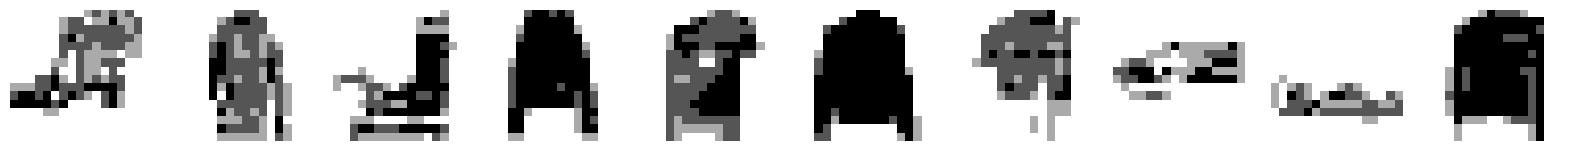

469/469 [==============================] - 15s 32ms/step - loss: 0.3250
Epoch 125/150
468/469 [============================>.] - ETA: 0s - loss: 0.3249
Saved to ./output/generated_img_124.png


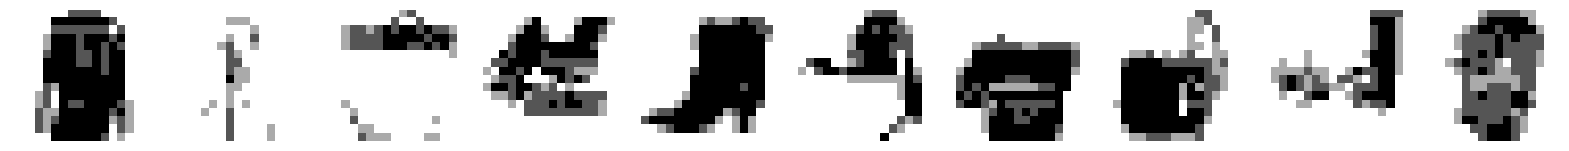

469/469 [==============================] - 15s 31ms/step - loss: 0.3249
Epoch 126/150
468/469 [============================>.] - ETA: 0s - loss: 0.3247
Saved to ./output/generated_img_125.png


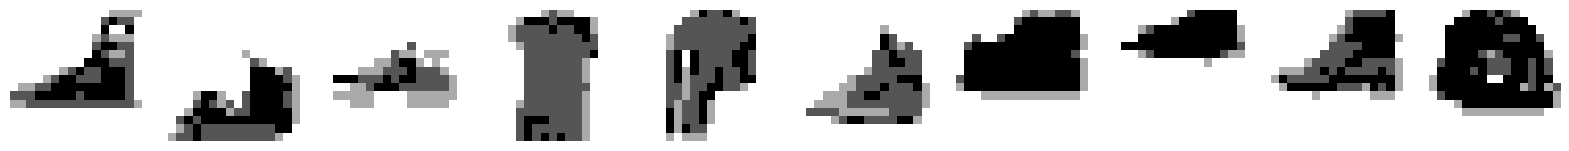

469/469 [==============================] - 15s 32ms/step - loss: 0.3247
Epoch 127/150
466/469 [============================>.] - ETA: 0s - loss: 0.3247
Saved to ./output/generated_img_126.png


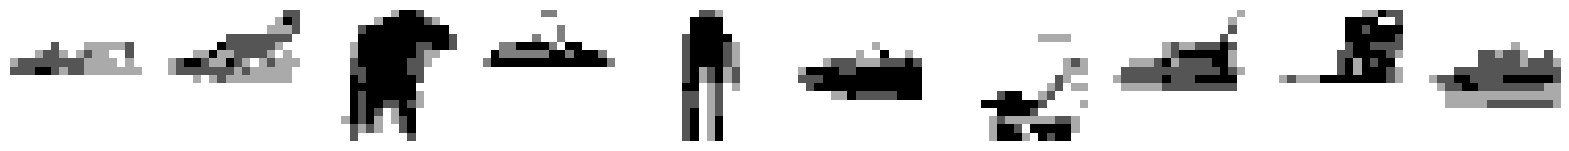

469/469 [==============================] - 15s 31ms/step - loss: 0.3247
Epoch 128/150
467/469 [============================>.] - ETA: 0s - loss: 0.3246
Saved to ./output/generated_img_127.png


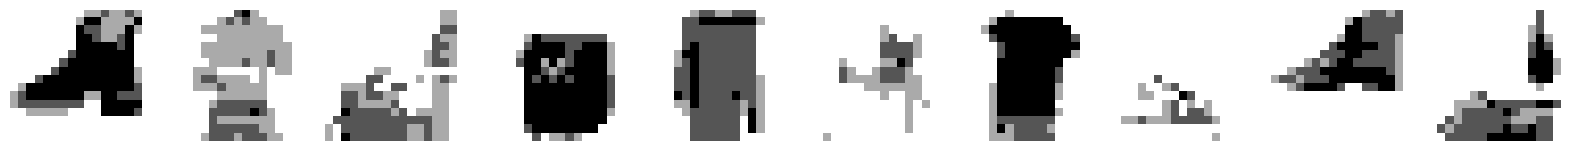

469/469 [==============================] - 15s 32ms/step - loss: 0.3246
Epoch 129/150
466/469 [============================>.] - ETA: 0s - loss: 0.3247
Saved to ./output/generated_img_128.png


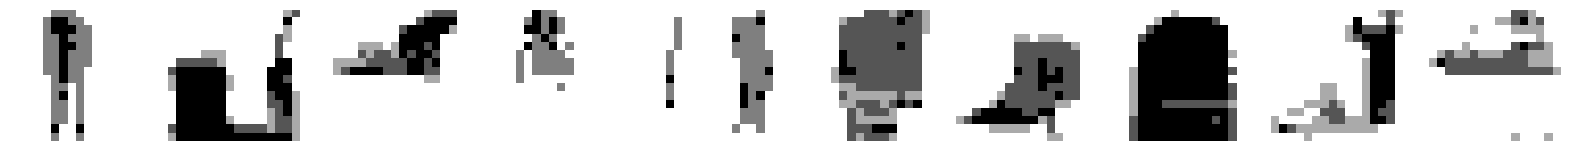

469/469 [==============================] - 15s 31ms/step - loss: 0.3247
Epoch 130/150
467/469 [============================>.] - ETA: 0s - loss: 0.3245
Saved to ./output/generated_img_129.png


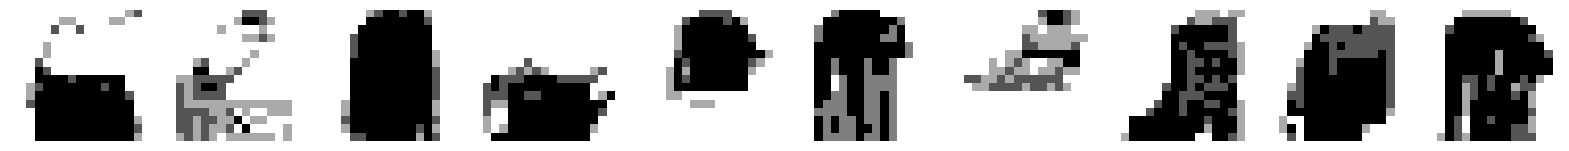

469/469 [==============================] - 15s 32ms/step - loss: 0.3245
Epoch 131/150
467/469 [============================>.] - ETA: 0s - loss: 0.3244
Saved to ./output/generated_img_130.png


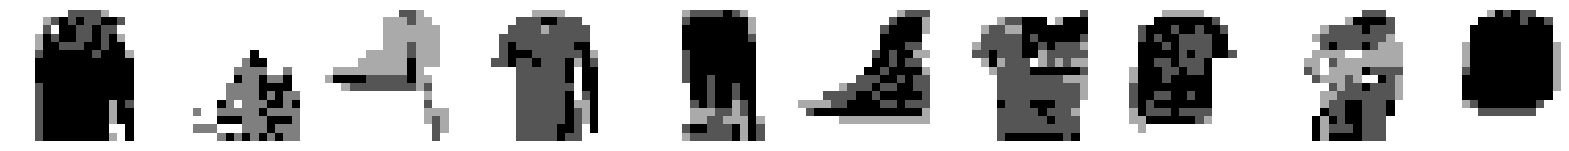

469/469 [==============================] - 15s 31ms/step - loss: 0.3244
Epoch 132/150
467/469 [============================>.] - ETA: 0s - loss: 0.3243
Saved to ./output/generated_img_131.png


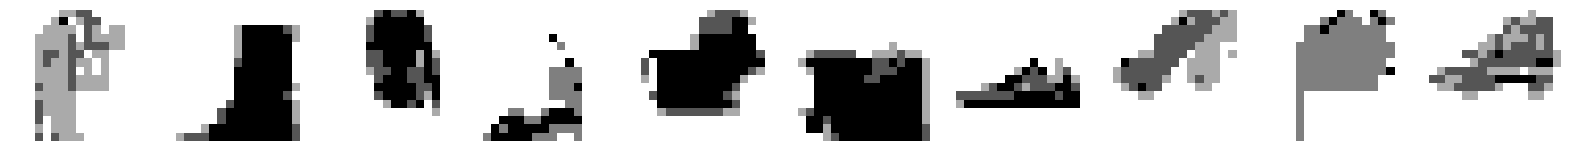

469/469 [==============================] - 15s 32ms/step - loss: 0.3243
Epoch 133/150
469/469 [==============================] - ETA: 0s - loss: 0.3242
Saved to ./output/generated_img_132.png


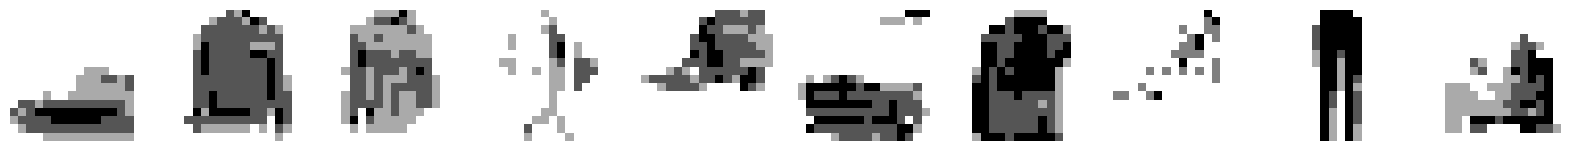

469/469 [==============================] - 15s 32ms/step - loss: 0.3242
Epoch 134/150
468/469 [============================>.] - ETA: 0s - loss: 0.3241
Saved to ./output/generated_img_133.png


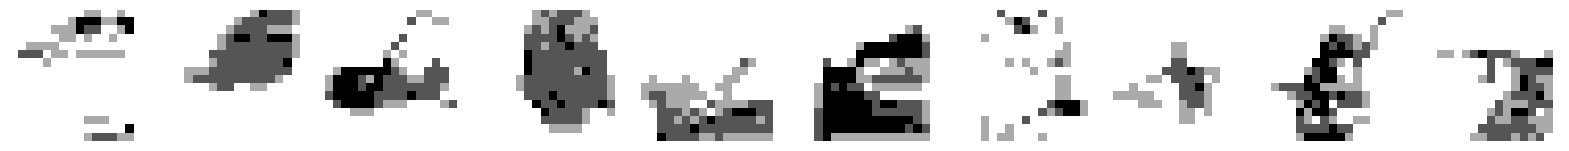

469/469 [==============================] - 15s 32ms/step - loss: 0.3241
Epoch 135/150
466/469 [============================>.] - ETA: 0s - loss: 0.3241
Saved to ./output/generated_img_134.png


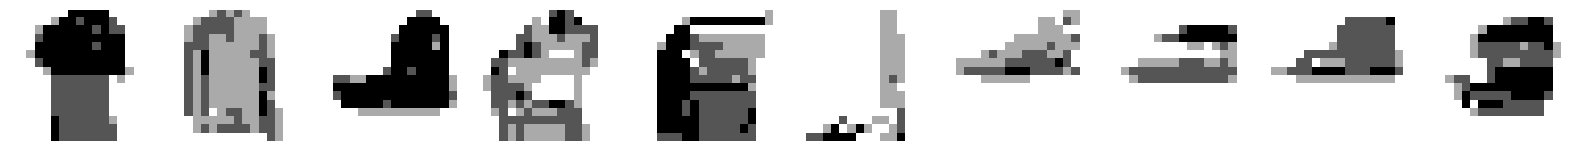

469/469 [==============================] - 15s 32ms/step - loss: 0.3240
Epoch 136/150
467/469 [============================>.] - ETA: 0s - loss: 0.3241
Saved to ./output/generated_img_135.png


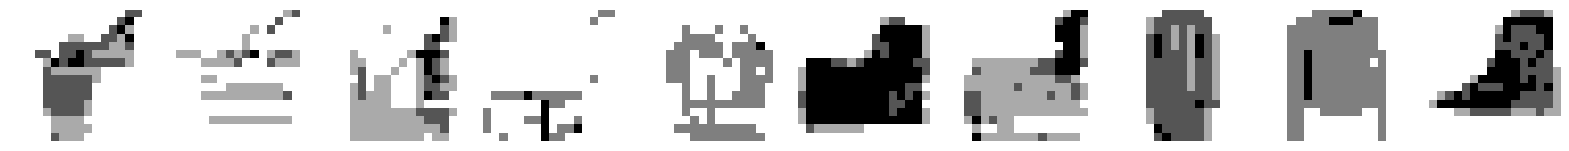

469/469 [==============================] - 15s 31ms/step - loss: 0.3241
Epoch 137/150
469/469 [==============================] - ETA: 0s - loss: 0.3238
Saved to ./output/generated_img_136.png


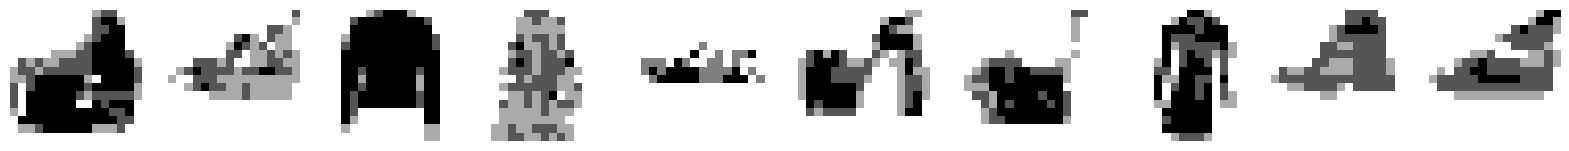

469/469 [==============================] - 15s 32ms/step - loss: 0.3238
Epoch 138/150
468/469 [============================>.] - ETA: 0s - loss: 0.3238
Saved to ./output/generated_img_137.png


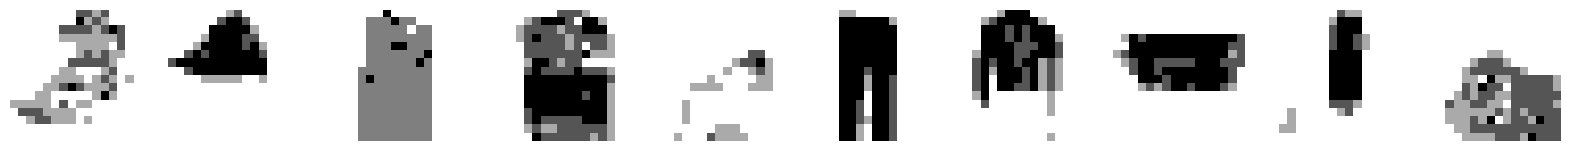

469/469 [==============================] - 15s 31ms/step - loss: 0.3238
Epoch 139/150
467/469 [============================>.] - ETA: 0s - loss: 0.3238
Saved to ./output/generated_img_138.png


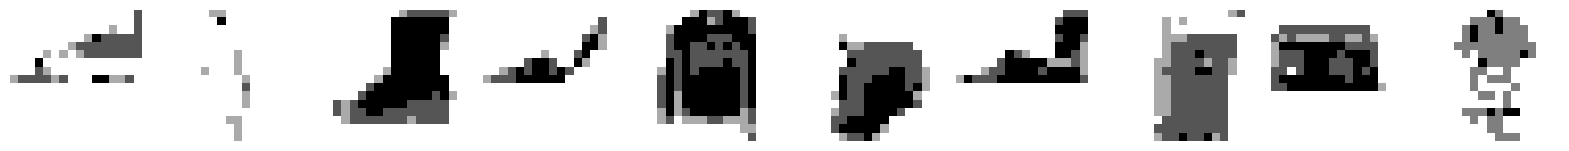

469/469 [==============================] - 15s 32ms/step - loss: 0.3238
Epoch 140/150
468/469 [============================>.] - ETA: 0s - loss: 0.3236
Saved to ./output/generated_img_139.png


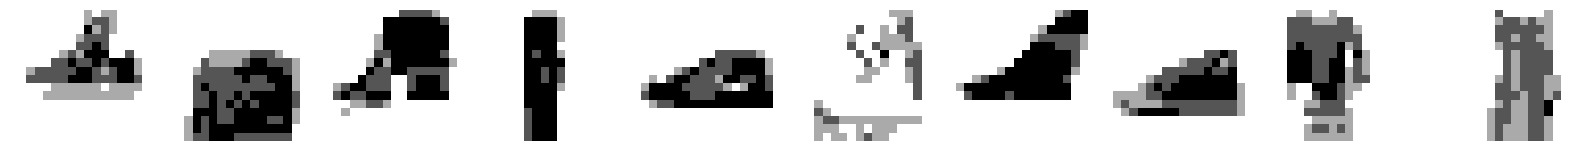

469/469 [==============================] - 15s 31ms/step - loss: 0.3236
Epoch 141/150
469/469 [==============================] - ETA: 0s - loss: 0.3236
Saved to ./output/generated_img_140.png


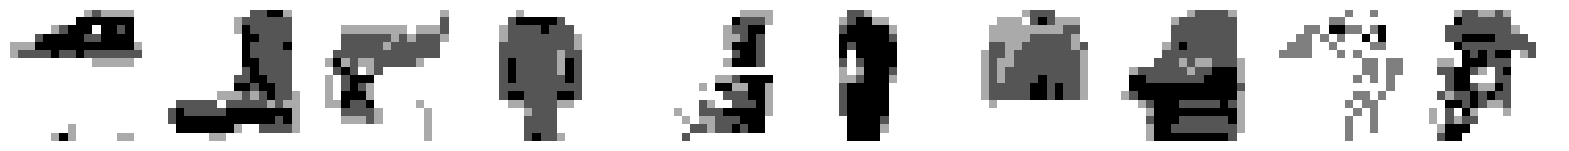

469/469 [==============================] - 15s 32ms/step - loss: 0.3236
Epoch 142/150
468/469 [============================>.] - ETA: 0s - loss: 0.3236
Saved to ./output/generated_img_141.png


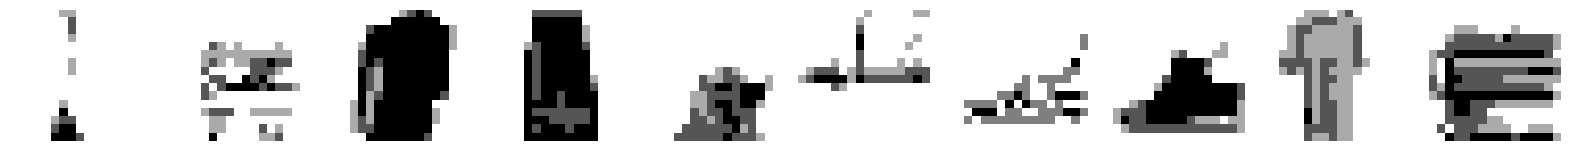

469/469 [==============================] - 15s 32ms/step - loss: 0.3236
Epoch 143/150
469/469 [==============================] - ETA: 0s - loss: 0.3235
Saved to ./output/generated_img_142.png


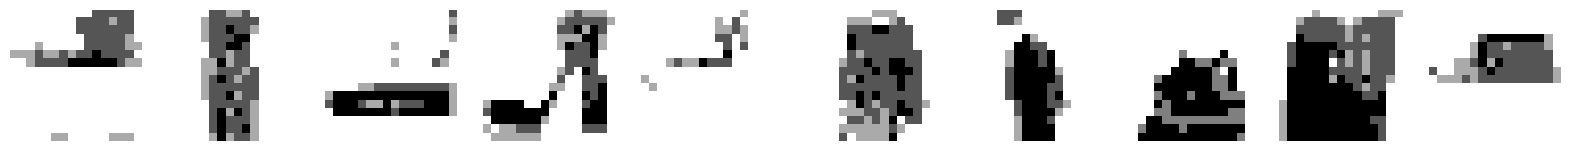

469/469 [==============================] - 15s 32ms/step - loss: 0.3235
Epoch 144/150
466/469 [============================>.] - ETA: 0s - loss: 0.3234
Saved to ./output/generated_img_143.png


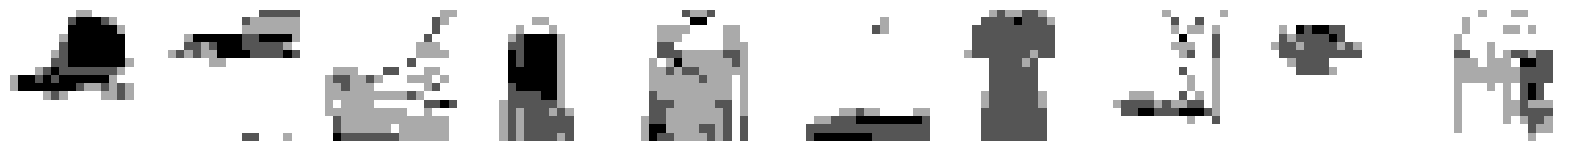

469/469 [==============================] - 15s 32ms/step - loss: 0.3234
Epoch 145/150
469/469 [==============================] - ETA: 0s - loss: 0.3233
Saved to ./output/generated_img_144.png


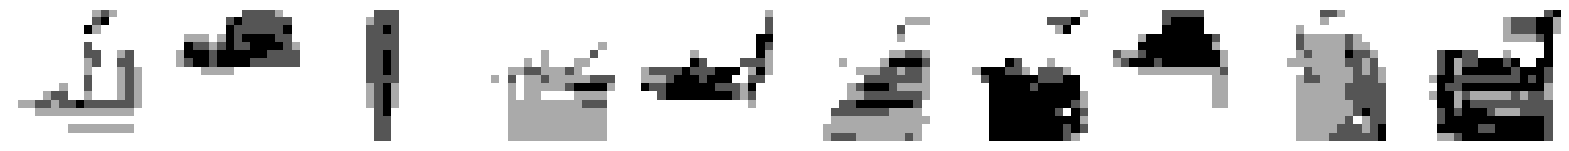

469/469 [==============================] - 15s 31ms/step - loss: 0.3233
Epoch 146/150
467/469 [============================>.] - ETA: 0s - loss: 0.3235
Saved to ./output/generated_img_145.png


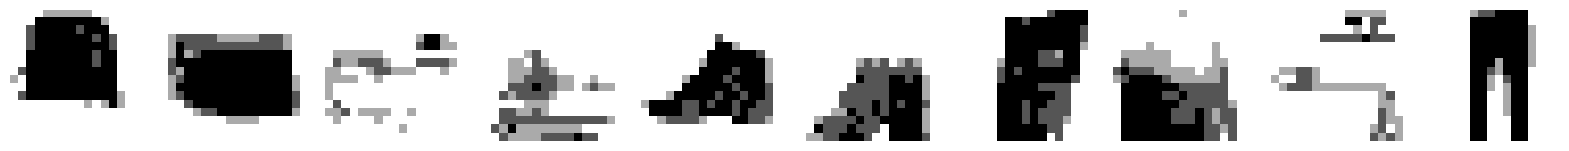

469/469 [==============================] - 15s 33ms/step - loss: 0.3234
Epoch 147/150
467/469 [============================>.] - ETA: 0s - loss: 0.3233
Saved to ./output/generated_img_146.png


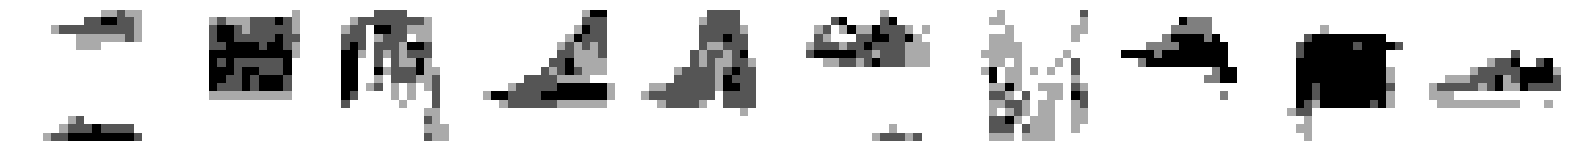

469/469 [==============================] - 15s 31ms/step - loss: 0.3233
Epoch 148/150
468/469 [============================>.] - ETA: 0s - loss: 0.3232
Saved to ./output/generated_img_147.png


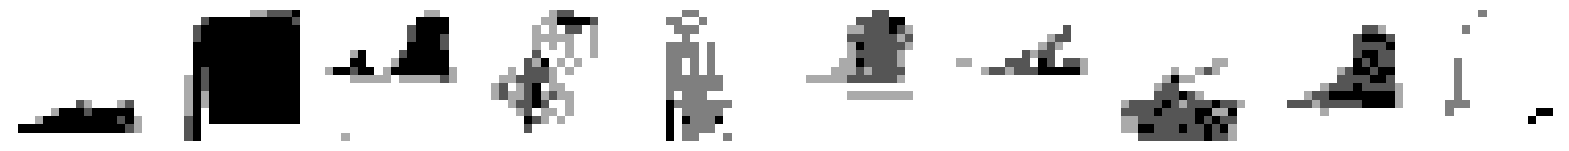

469/469 [==============================] - 15s 32ms/step - loss: 0.3232
Epoch 149/150
466/469 [============================>.] - ETA: 0s - loss: 0.3231
Saved to ./output/generated_img_148.png


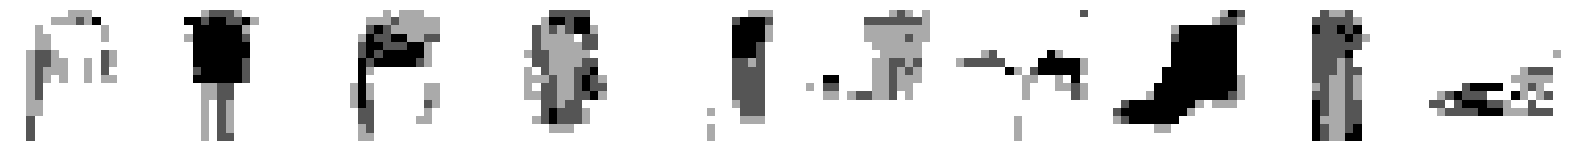

469/469 [==============================] - 15s 31ms/step - loss: 0.3231
Epoch 150/150
469/469 [==============================] - ETA: 0s - loss: 0.3231
Saved to ./output/generated_img_149.png


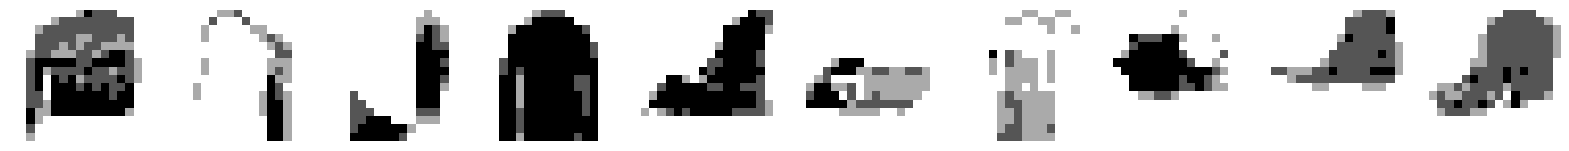

469/469 [==============================] - 15s 32ms/step - loss: 0.3231


In [17]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

In [18]:
generated_images = img_generator_callback.generate(temperature=1.0)

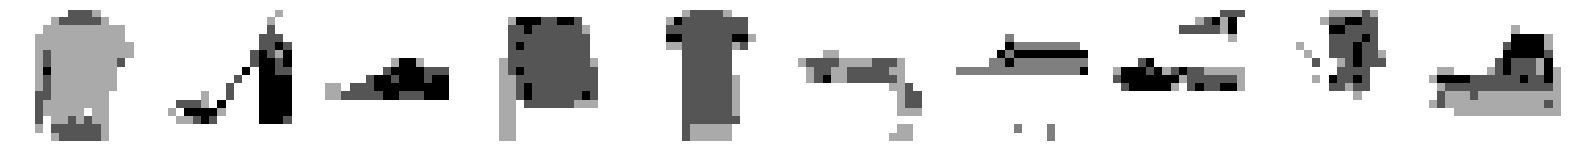

In [19]:
display(generated_images)